# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109B Data Science 2: Advanced Topics in Data Science 

##  Project F: Measuring the Shape and Brightness of Galaxies with Neural Networks

### Group 75: Dmitry Vukolov, Ning Xu, Rohit Beri, Sunil Chomal


**Harvard University**<br/>
**Spring 2020**<br/>
**Instructors**: Pavlos Protopapas, Mark Glickman and Chris Tanner<br/>
**Project Advisors**: Douglas Finkbeiner and Jun Yin<br/>


<hr style="height:2pt">

---



In [1]:
# RUN THIS CELL
import requests
from IPython.core.display import HTML, display

styles = requests.get(
    "https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css"
).text
HTML(styles)

## <div class="theme"> Outline </div> 

1. Overview
2. Loading the Data
3. Structure and Size of the Data
4. Basic Statistics of the Data 
5. Visualization of the Image Data 
6. Distributions of the Labels and Numerical Attributes 
7. Parametric Image Generation
8. Summary

## <div class="theme"> Overview </div> 

<div style="border: 3px solid #800080; padding: 10px"> 

## Creating Galaxy images using GalSim

## <div class="theme"> Part 0 </div> 

<div style="border: 3px solid #800080; padding: 10px"> 

## Load Libraries and Create Helper Functions

### <div class='exercise'> <b> Step 0: Load the essential libraries </b> </div>

<div class='gc'> <b> Load Standard Libraries </b> </div>

In [2]:
# Load useful libraries
import os
import sys
import copy
import math
import time
import random
import numpy as np
import pandas as pd
import ipywidgets as widgets

# Import h5py for reading h5 files
import h5py

# Load galsim for data generation
import galsim

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Tweak plot resolution and styling
%config InlineBackend.figure_format = "retina"
sns.set(style="white", palette=None, rc={"axes.linewidth": 1})
plt.rc("image", cmap="viridis")

<div class='gc'> <b> Load Machine Learning Libraries </b> </div>

In [3]:
# Load useful functions from scikit-lear
from sklearn.preprocessing import MinMaxScaler

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import initializers
from tensorflow.keras.metrics import *
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

### <div class='exercise'> <b> Step 1: Create Helper Functions </b> </div>

<div class='gc'> <b> Function to Load Data </b> </div>

In [4]:
def load_data(set=1):
    # Path for the Traning and Validation Data
    dataPath = ["./cs109b-project/data/data_v1.npz", 
                "./cs109b-project/data/data_v2.npz", 
                "./cs109b-project/data/data_v3.npz",
                "./cs109b-project/data/snr30.npz",
                "./cs109b-project/data/snr60.npz"
               ]
    
    
    # Load dataset
    with np.load(dataPath[set-1]) as data:
        print("\nAvailable variables:")
        
        for file in data.files:
            print("    {}".format(file))

        image = data["img"]
        image_nonoise = data["img_nonoise"]
        label = data["label"]
        snr = data["snr"]
        sigma = data["sigma"]
        psf = data["psf_r"]
    
    
    # Structure and Size of the Data
    print("\nImage Shape            = {}".format(image.shape))
    print("No-noise Image Shape   = {}".format(image_nonoise.shape))
    print("Label Shape            = {}".format(label.shape))
    print("SNR Shape              = {}".format(snr.shape))
    print("Sigma Shape            = {}".format(sigma.shape))
    print("PSF-R Shape            = {}".format(psf.shape))
    
    
    # Return Data
    return (image, 
            image_nonoise, 
            label, 
            snr
           )

<div class='gc'> <b> Function to Normalize data and Split data into Training and Validation</b> </div>

In [5]:
def normalize_and_split(image, image_nonoise, label, snr):
    # 90% of the data to be kept for training
    n_train = int(snr.shape[0] * 0.9)
    
    
    # Reshape images to 3D array
    image = image.reshape(image.shape[0], image.shape[1], image.shape[2], 1)
    image_nonoise = image_nonoise.reshape(image_nonoise.shape[0], image_nonoise.shape[1], image_nonoise.shape[2], 1)

    
    # Split into 90% train and 10% test (creates a view of the array)
    image_train, image_val = image[:n_train], image[n_train:]
    image_nonoise_train, image_nonoise_val = image_nonoise[:n_train], image_nonoise[n_train:]
    label_train, label_val = label[:n_train], label[n_train:]
    snr_train, snr_val = snr[:n_train], snr[n_train:]


    # Zero-One Normalization of the labels
    label_min = label.min(axis=0)
    label_max = label.max(axis=0)
    label_diff = label_max - label_min

    label_train = (label_train - label_min)/label_diff
    label_val = (label_val - label_min)/label_diff


    # Zero-One Normalization of the no-noise images
    image_nonoise_min = image_nonoise.min()
    image_nonoise_max = image_nonoise.max()
    image_nonoise_diff = (image_nonoise_max - image_nonoise_min)

    image_nonoise_train = (image_nonoise_train - image_nonoise_min)/image_nonoise_diff
    image_nonoise_val = (image_nonoise_val - image_nonoise_min)/image_nonoise_diff


    # Zero-One Normalization of the noisy images
    image_min = image.min()
    image_max = image.max()
    image_diff = (image_max - image_min)

    image_train = (image_train - image_min)/image_diff
    image_val = (image_val - image_min)/image_diff


    # Compute Image Statistics
    stats = np.hstack([image.mean(axis=(1,2)).reshape(-1,1), image.std(axis=(1,2)).reshape(-1,1)])
    stats_train, stats_val = stats[:n_train], stats[n_train:]
    
    
    # Number of Training and Validation Points
    print("\nNumber of Training Points:    {}".format(n_train))
    print("Number of Validation Points:  {}\n".format(snr.shape[0] - n_train))
    
    
    #Return Training and Validation set
    return (image_train, image_val,
            image_nonoise_train, image_nonoise_val,
            label_train, label_val,
            snr_train, snr_val,
            stats_train, stats_val,
            (label_min, label_diff),
            (image_min, image_diff),
            (image_nonoise_min, image_nonoise_diff)
           )

<div class='gc'> <b> Function to Normalize Test Data and generate Image Pixel Statistics</b> </div>

In [6]:
def norm_test_data(image, image2, label, scaler_label, scaler_image, scaler_nonoise):
    # Normalize noisy image
    image = image.reshape(image.shape[0], image.shape[1], image.shape[2], 1)
    image_min = scaler_image[0]
    image_diff = scaler_image[1]
    image = (image - image_min)/image_diff
    
    
    # Normalize clean image
    image2 = image2.reshape(image2.shape[0], image2.shape[1], image2.shape[2], 1)
    image_min = scaler_nonoise[0]
    image_diff = scaler_nonoise[1]
    image2 = (image2 - image_min)/image_diff
    
    # Normalize labels
    label = ((label - scaler_label[0])/scaler_label[1])
    
    # Generate image stats
    stats = np.hstack([image.mean(axis=(1,2)).reshape(-1,1), image.std(axis=(1,2)).reshape(-1,1)])
    
    
    # Return normalized test data
    return (image,
            image2,
            label,
            stats
           )

<div class='gc'> <b> Function to create Tensorflow Dataset </b> </div>

In [7]:
def create_dataset(test=False):
    # Check if creating dataset for testing
    if test:
        # Create Training Dataset    
        testing = tf.data.Dataset.from_tensor_slices({
        "Image": image_test,
        "No-noise Image": image_nonoise_test,
        "Labels": label_test,
        "Stats": stats_test
        })
        return testing
    
    else:
        # Create Training Dataset    
        training = tf.data.Dataset.from_tensor_slices({
            "Image": image_train,
            "No-noise Image": image_nonoise_train,
            "Labels": label_train,
            "Stats": stats_train
        })
        # Create Validation Dataset
        validation = tf.data.Dataset.from_tensor_slices({
            "Image": image_val,
            "No-noise Image": image_nonoise_val,
            "Labels": label_val,
            "Stats": stats_val
        })
        return training, validation

<div class='gc'> <b> Define pipeline functions to structure dataset </b> </div>

In [8]:
def pipeline_label_to_clean_image(element):
    image = element['No-noise Image']
    label = tf.cast(element['Labels'], tf.float32)
    
    return (label, image)

In [9]:
def pipeline_noisy_image_to_label(element):
    image = element['Image']
    label = tf.cast(element['Labels'], tf.float32)
    stats = tf.cast(element['Stats'], tf.float32)
    
    return ((image, stats), label)

In [10]:
def pipeline_noisy_image_to_clean_image(element):
    image = element['Image']
    stats = tf.cast(element['Stats'], tf.float32)
    clean = element['No-noise Image']
    label = tf.cast(element['Labels'], tf.float32)
    
    return ((image, stats), (clean, label))

<div class='gc'> <b> Function to create data pipeline </b> </div>

In [11]:
def create_data_pipeline(training, validation=None, test=False):
    # Check if creating data pipeline for testing
    if test:
        # Data pipeline for testing
        test_ds = training.map(
            pipeline_noisy_image_to_clean_image).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
        
        # Return testing pipeline
        return test_ds
    
    else:
        # Data pipeline for Decoder
        tr_ds = training.map(
            pipeline_label_to_clean_image).shuffle(
            shuffle).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

        val_ds = validation.map(
            pipeline_label_to_clean_image).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)


        # Data pipeline for Encoder
        tr_ds_en = training.map(
            pipeline_noisy_image_to_label).shuffle(
            shuffle).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

        val_ds_en = validation.map(
            pipeline_noisy_image_to_label).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)


        # Data pipeline for Conditional Auto-encoder
        tr_ds_AE = training.map(
            pipeline_noisy_image_to_clean_image).shuffle(
            shuffle).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

        val_ds_AE = validation.map(
            pipeline_noisy_image_to_clean_image).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

        # Return Pipeline
        return (tr_ds, val_ds,
                tr_ds_en, val_ds_en,
                tr_ds_AE, val_ds_AE
               )

<div class='gc'> <b> Function defining convolution encoder layer</b> </div>

In [12]:
class ConvEncoder(layers.Layer):
    """
    Convolutional Encoder Layer Class.
    Converts an input into a latent representation.
    """

    def __init__(self, input_shape, dropout_rate=0.0, name='encoder', **kwargs):
        """
        Initializes the encoder layers and saves them as local attribute.
        
        Input:
        -input_dim: 3D-tuple with (rows, cols, channels) input image dimensions.
        
        Returns nothing.
        """
        super(ConvEncoder, self).__init__(name=name, input_shape=input_shape, **kwargs)
        
        self.conv1 = layers.Conv2D(filters=32, kernel_size=(3,3), padding='same', strides=(2,2))
        self.lRelu1 = layers.LeakyReLU()
        self.drop1 = layers.Dropout(dropout_rate)
        
        self.conv2 = layers.Conv2D(filters=64, kernel_size=(3,3), padding='same', strides=(2,2))
        self.lRelu2 = layers.LeakyReLU()
        self.drop2 = layers.Dropout(dropout_rate)
        
        self.conv3 = layers.Conv2D(filters=128, kernel_size=(3,3), padding='same', strides=(2,2))
        self.lRelu3 = layers.LeakyReLU()
        self.drop3 = layers.Dropout(dropout_rate)
        
        self.conv4 = layers.Conv2D(filters=256, kernel_size=(3,3), padding='same', strides=(2,2))
        self.lRelu4 = layers.LeakyReLU()
        self.drop4 = layers.Dropout(dropout_rate)
        
        self.conv5 = layers.Conv2D(filters=512, kernel_size=(3,3), padding='same', strides=(2,2))
        self.lRelu5 = layers.LeakyReLU()
        self.drop5 = layers.Dropout(dropout_rate)
        
        self.conv6 = layers.Conv2D(filters=2048, kernel_size=(3,3), padding='same', strides=(2,2))
        self.lRelu6 = layers.LeakyReLU()
        self.drop6 = layers.Dropout(dropout_rate)
        

    def call(self, inputs, training=None):
        """
        Runs the encoding inference for `inputs`.
        
        Inputs:
        -inputs: 4D-tensor with dimension (batch_size, self.input_dim).
        """
        
        z = self.conv1(inputs)
        z = self.lRelu1(z)
        z = self.drop1(z)
        
        z = self.conv2(z)
        z = self.lRelu2(z)
        z = self.drop2(z)
        
        z = self.conv3(z)
        z = self.lRelu3(z)
        z = self.drop3(z)
        
        z = self.conv4(z)
        z = self.lRelu4(z)
        z = self.drop4(z)
        
        z = self.conv5(z)
        z = self.lRelu5(z)
        z = self.drop5(z)
        
        z = self.conv6(z)
        z = self.lRelu6(z)
        z = self.drop6(z)
        
        return z

<div class='gc'> <b> Function defining convolution decoder layer</b> </div>

In [13]:
class ConvDecoder(layers.Layer):
    """
    Convolutional Decoder Layer Class.
    Converts z, the encoded digit vector, back into a readable digit.
    """

    def __init__(self, input_shape, dropout_rate=0.0, name='decoder', **kwargs):
        """
        Initializes the decoder architecture and saves it as a local attribute.
        
        Input:
        -input_shape: 3D-tuple with (rows, cols, channels) input representation.
        
        Returns nothing.
        """
        super(ConvDecoder, self).__init__(name=name, input_shape=input_shape, **kwargs)
        
        self.convT1 = layers.Conv2DTranspose(512, kernel_size=(3,3), strides=(2,2), padding='same')
        self.lRelu1 = layers.LeakyReLU()
        self.drop1 = layers.Dropout(dropout_rate)
        
        self.convT2 = layers.Conv2DTranspose(256, kernel_size=(3,3), strides=(2,2), padding='same')
        self.lRelu2 = layers.LeakyReLU()
        self.drop2 = layers.Dropout(dropout_rate)
        
        self.convT3 = layers.Conv2DTranspose(128, kernel_size=(3,3), strides=(2,2), padding='same')
        self.lRelu3 = layers.LeakyReLU()
        self.drop3 = layers.Dropout(dropout_rate)
        
        self.convT4 = layers.Conv2DTranspose(64, kernel_size=(3,3), strides=(2,2), padding='same')
        self.lRelu4 = layers.LeakyReLU()
        self.drop4 = layers.Dropout(dropout_rate)
        
        self.convT5 = layers.Conv2DTranspose(32, kernel_size=(3,3), strides=(2,2), padding='same')
        self.lRelu5 = layers.LeakyReLU()
        self.drop5 = layers.Dropout(dropout_rate)
        
        self.convT6 = layers.Conv2DTranspose(1, kernel_size=(3,3), strides=(2,2), padding='same', 
                                             activation='sigmoid')
        

    def call(self, inputs, training=None):
        """
        Runs the encoding inference for `inputs`.
        
        Inputs:
        -inputs: 4D-tensor with dimension (batch_size, self.input_dim).
        """
        
        x = self.convT1(inputs)
        x = self.lRelu1(x)
        x = self.drop1(x)
        
        x = self.convT2(x)
        x = self.lRelu2(x)
        x = self.drop2(x)
        
        x = self.convT3(x)
        x = self.lRelu3(x)
        x = self.drop3(x)
        
        x = self.convT4(x)
        x = self.lRelu4(x)
        x = self.drop4(x)
        
        x = self.convT5(x)
        x = self.lRelu5(x)
        x = self.drop5(x)
        
        x = self.convT6(x)
        
        return x

<div class='gc'> <b> Function to create Conditional Encoder: Noisy Image to Label </b> </div>

In [14]:
# Create Conditional Model
def create_cond_encoder(loss):

    # Create Conditional Encoder
    input_encoder_img = layers.Input(input_shape_img)
    input_encoder_stats = layers.Input(input_shape_stats)
    
    x = ConvEncoder(input_shape_img)(input_encoder_img)
    x = layers.Flatten()(x)
    
    x = layers.concatenate([x, input_encoder_stats])
    
    x = layers.Dense(2048)(x)
    x = layers.LeakyReLU()(x)
    x = layers.Dropout(dropout)(x)
    
    x = layers.Dense(1024)(x)
    x = layers.Dropout(dropout)(x)
    
    
    # Output later of the conditional encoder
    latent_z = layers.Dense(latent_z_dim_labels, activation='sigmoid')(x)
    
    
    # Conditional Encoder Model
    encoder = tf.keras.Model([input_encoder_img, input_encoder_stats], latent_z, name='Cond_Encoder')
    
    # Define Optimizer
    optimizer = optimizers.Adam(learning_rate=0.001)
    
    # Compile the model
    encoder.compile(optimizer, loss=loss)
    
    # Display the model summary
    display(encoder.summary())
    
    
    # Return conditional encoder
    return encoder

<div class='gc'> <b> Function to create Decoder: Label to Noiseless Image </b> </div>

In [15]:
# Create Decoder Model
def create_decoder(loss):

    # Create Decoder
    input_decoder_labels = layers.Input(latent_z_dim_labels)
    
    x = layers.Dense(1024)(input_decoder_labels)
    x = layers.Dropout(dropout)(x)
    
    x = layers.Dense(2048)(x)
    x = layers.LeakyReLU()(x)
    x = layers.Dropout(dropout)(x)
    
    x = layers.Reshape(latent_dim)(x)
    recon = ConvDecoder(latent_dim)(x)
    
    
    # Decoder Model
    decoder = tf.keras.Model(input_decoder_labels, recon, name='Decoder')
    
    # Define Optimizer
    optimizer = optimizers.Adam(learning_rate=0.001)
    
    # Compile the model
    decoder.compile(optimizer, loss=loss)
    
    # Display the model summary
    display(decoder.summary())
    
    
    # Return decoder
    return decoder

<div class='gc'> <b> Function to create Conditional Auto-encoder: Noisy Image to Noiseless Image </b> </div>

In [16]:
def create_CAE(encoder, decoder):
    input_encoder_img = layers.Input(input_shape_img)
    input_encoder_stats = layers.Input(input_shape_stats)
    
    labels = encoder([input_encoder_img, input_encoder_stats])
    recons = decoder(labels)
    
    # Conditional AE Model
    CAE = tf.keras.Model([input_encoder_img, input_encoder_stats], [recons, labels], name='CAE')
    
    # Define Optimizer
    optimizer = optimizers.Adam()
    
    # Define Loss
    loss = {
        'Cond_Encoder': 'binary_crossentropy',
        'Decoder': 'binary_crossentropy'
    }
    
    # Define Loss
    lossWeights = {
        'Cond_Encoder': 5.0, 
        'Decoder': 1.0}
    
    # Compile the model
    CAE.compile(optimizer, loss=loss, loss_weights=lossWeights)
    
    # Display the model summary
    display(CAE.summary())
    
    # Return reverse decoder
    return CAE

<div class='gc'> <b> Function to train Conditional Auto-encoder </b> </div>

In [17]:
def train_CAE(CAE, set=1):
    # Scheduler for learning rate
    def scheduler(epoch):
        if epoch < 5:
            return 0.001
        else:
            return 0.001 * np.exp(0.1 * (5 - epoch))

    # Check if model is pretrained
    try:
        CAE.load_weights(paths[set-1])
        print("Training Loss:   {}".format(CAE.evaluate(tr_ds_AE)))
        print("Validation Loss: {}".format(CAE.evaluate(val_ds_AE)))
        
    # Train if model is not pre-trained
    except:
        print("\nTraining Encoder....")
        history = encoder.fit(
            tr_ds_en, 
            epochs=epochs, 
            verbose=1,
            validation_data=val_ds_en,
            callbacks=[
                EarlyStopping(monitor='val_loss', min_delta=0.00005, patience=3, restore_best_weights=True)
            ]
        )
        
        print("\nTraining Decoder....")
        history = decoder.fit(
            tr_ds, 
            epochs=epochs,
            verbose=1,
            validation_data=val_ds,
            callbacks=[
                EarlyStopping(monitor='val_loss', min_delta=0.00005, patience=3, restore_best_weights=True)
            ]
        )
        
        print("\nTraining Conditional Auto-Encoder....")
        history = CAE.fit(
            tr_ds_AE, 
            epochs=epochs, 
            verbose=1,
            validation_data=val_ds_AE,
            callbacks=[
                EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=5, restore_best_weights=True),
                LearningRateScheduler(scheduler)
            ]
        )
        
        CAE.save_weights(paths[set-1])

<div class='gc'> <b> Function to generating reconstructed images for visual inspection </b> </div>

In [18]:
def generate_images(CAE, val_ds_AE):
    test = val_ds_AE.take(1)
    (images, stats), (clean, labels) = next(iter(test))
    pred_img, pred_lab = CAE.predict([images, stats])
    pred = pred_img.reshape(pred_img.shape[:-1])

    fig, ax = plt.subplots(1,8, figsize=(20,3))
    plt.suptitle("Generated Images", fontsize=25)
    for j in range(8):
        ax[j].imshow(pred[idx[j]])
    plt.show()


    fig, ax = plt.subplots(1,8, figsize=(20,3))
    plt.suptitle("Clean Images", fontsize=25)
    for j in range(8):
        ax[j].imshow(clean[idx[j]].numpy().reshape(64,64))
    plt.show()

    fig, ax = plt.subplots(1,8, figsize=(20,3))
    plt.suptitle("Original Noisy Images", fontsize=25)
    for j in range(8):
        ax[j].imshow(images[idx[j],:,:,0].numpy())
    plt.show()


    fig, ax = plt.subplots(1,8, figsize=(20,3))
    plt.suptitle("Residual Unscaled (Clean minus Generated)", fontsize=25)
    for j in range(8):
        ax[j].imshow(np.abs(clean[idx[j]].numpy().reshape(64,64)-pred[idx[j]]), vmin=0, vmax=1)
    plt.show()

    fig, ax = plt.subplots(1,8, figsize=(20,3))
    plt.suptitle("Residual Scaled Absolute Values (Clean minus Generated scaled to {0,1})", fontsize=25)
    for j in range(8):
        ax[j].imshow(np.abs(clean[idx[j]].numpy().reshape(64,64)-pred[idx[j]]))
    plt.show()


    fig, ax = plt.subplots(1,8, figsize=(20,3))
    plt.suptitle("Residual Scaled (Clean minus Generated sclaed to {0,1})", fontsize=25)
    for j in range(8):
        ax[j].imshow((clean[idx[j]].numpy().reshape(64,64)-pred[idx[j]]))
    plt.show()

<div class='gc'> <b> Function for Variance Analysis of the Labels </b> </div>

In [19]:
def variance_analysis(CAE, ds, scaler, label_v, test=False):
    np.set_printoptions(precision=5, suppress=True)
    
    _, pred = CAE.predict(ds)
    error = pred - label_v
    
    bias = error.mean(axis=0)*scaler[1]
    MSE = (error**2).mean(axis=0)
    RMSE = np.sqrt(MSE)*scaler[1]

    label_var = (label_v.std(axis=0))**2

    unexplained_var = MSE/label_var

    results = pd.DataFrame({'Bias': bias, 'RMSE': RMSE, },
                          index=['Flux', 'Sersic Index', 'Sersic Radius', 'g1', 'g2'])
    if not test:
        results['Un-Explained Variance'] = unexplained_var
        results['Explained Variance'] = 1 -unexplained_var
        
    display(results)
    
    return pred

<div class='gc'> <b> Function for comparing True Labels with Predicted Labels </b> </div>

In [20]:
def true_vs_pred(pred):
    titles = ['Flux', 'Sersic Index', 'Sersic Radius', 'g1']
    
    n = min(pred.shape[0], 5000)

    fig, ax = plt.subplots(2,2, figsize=(20, 20))

    for i in range(4):
        im = ax[i//2, i%2].scatter(label_val[:n,i], pred[:n,i], c=snr_val[:n], marker='.', cmap='RdYlBu')
        fig.colorbar(im, ax=ax[i//2, i%2])
        ax[i//2, i%2].set_title(titles[i], fontsize=20)
        ax[i//2, i%2].set_xlabel('True Value', fontsize=16)
        ax[i//2, i%2].set_ylabel('Predicted Value', fontsize=16)

### <div class='exercise'> <b> Step 3: Define Global Variables </b> </div>

In [21]:
# Model Weights Path
paths = [
    './model/rev_AE6_1',
    './model/rev_AE6_2',
    './model/rev_AE6_3'
]

# Batch Size
batch_size = 256

# Shuffling Parameter for Pipeline
shuffle = 1024

# Encoder Input Dimension
input_shape_img = (64,64,1)
input_shape_stats = (2,)

# Dropout rate for dense layers
dropout = 0.5

# Encoder Output dimension - Decoder Input Dimension
latent_z_dim_labels = 5

# Decoder latent dimension
latent_dim = (1,1,2048)

# Define Model loss
enc_loss = losses.BinaryCrossentropy()
dec_loss = losses.BinaryCrossentropy()

# Number of Training Epochs
epochs = 50

# 8 random numbers for image visualization
idx = np.random.randint(batch_size, size=8)

## <div class="theme"> Part 1 </div> 

<div style="border: 3px solid #800080; padding: 10px"> 

## GalSim Images with fixed Sigma and PSF

### <div class='exercise'> <b> Step 1: Load the Training and Validation dataset with fixed noise and fixed PSF </b> </div>

In [22]:
# Read the data set
(image, 
 image_nonoise, 
 label, 
 snr) = load_data(set=1)


Available variables:
    img
    img_nonoise
    label
    psf_r
    snr
    sigma
    train_test

Image Shape            = (200000, 64, 64)
No-noise Image Shape   = (200000, 64, 64)
Label Shape            = (200000, 5)
SNR Shape              = (200000,)
Sigma Shape            = (200000,)
PSF-R Shape            = (200000,)


### <div class='exercise'> <b> Step 2: Split the data into Training and Validation, Normalize the data and Generate Image Pixel Statistics </b> </div>

In [23]:
(image_train, image_val,
 image_nonoise_train, image_nonoise_val,
 label_train, label_val,
 snr_train, snr_val,
 stats_train, stats_val,
 scaler_label1,
 scaler_image1,
 scaler_nonoise1) = normalize_and_split(image, image_nonoise, label, snr)


Number of Training Points:    180000
Number of Validation Points:  20000



### <div class='exercise'> <b> Step 3: Create Data Pipeline </b> </div>

<div class='gc'> <b> Function to Load Data and Divide data into Training and Validation Set </b> </div>

In [24]:
# Create Tensorflow Dataset
training, validation = create_dataset()

<div class='gc'> <b> Create dataset pipeline </b> </div>

In [25]:
(tr_ds, val_ds,
 tr_ds_en, val_ds_en,
 tr_ds_AE, val_ds_AE) = create_data_pipeline(training, validation)

### <div class='exercise'> <b> Step 4: Create Conditional Auto-encoder </b> </div>

In [26]:
# Clear Session
K.clear_session()

# Create Conditional Encoder
encoder = create_cond_encoder(enc_loss)

# Create Decoder
decoder = create_decoder(dec_loss)

# Create Conditional Autoencoder
CAE = create_CAE(encoder, decoder)

Model: "Cond_Encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
encoder (ConvEncoder)           (None, 1, 1, 2048)   11007232    input_1[0][0]                    
__________________________________________________________________________________________________
flatten (Flatten)               (None, 2048)         0           encoder[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2)]          0                                            
_______________________________________________________________________________________

None

Model: "Decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 5)]               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              6144      
_________________________________________________________________
dropout_8 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 2048)              2099200   
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 2048)              0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 2048)              0         
_________________________________________________________________
reshape (Reshape)            (None, 1, 1, 2048)        0   

None

Model: "CAE"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
Cond_Encoder (Model)            (None, 5)            17310981    input_4[0][0]                    
                                                                 input_5[0][0]                    
__________________________________________________________________________________________________
Decoder (Model)                 (None, 64, 64, 1)    13110529    Cond_Encoder[1][0]             

None

### <div class='exercise'> <b> Step 5: Train Conditional Auto-encoder </b> </div>

In [27]:
train_CAE(CAE, set=1)

704/704 [==============================] - 141s 200ms/step - loss: 2.8293 - Decoder_loss: 0.0120 - Cond_Encoder_loss: 0.5635
Training Loss:   [2.829328116029501, 0.012018681, 0.5634618]
79/79 [==============================] - 16s 198ms/step - loss: 2.8391 - Decoder_loss: 0.0121 - Cond_Encoder_loss: 0.5654
Validation Loss: [2.8391332083110568, 0.012093837, 0.56540793]


### <div class='exercise'> <b> Step 6: Performance Analysis </b> </div>

<div class='gc'> <b> Generating reconstructed images for visual inspection </b> </div>

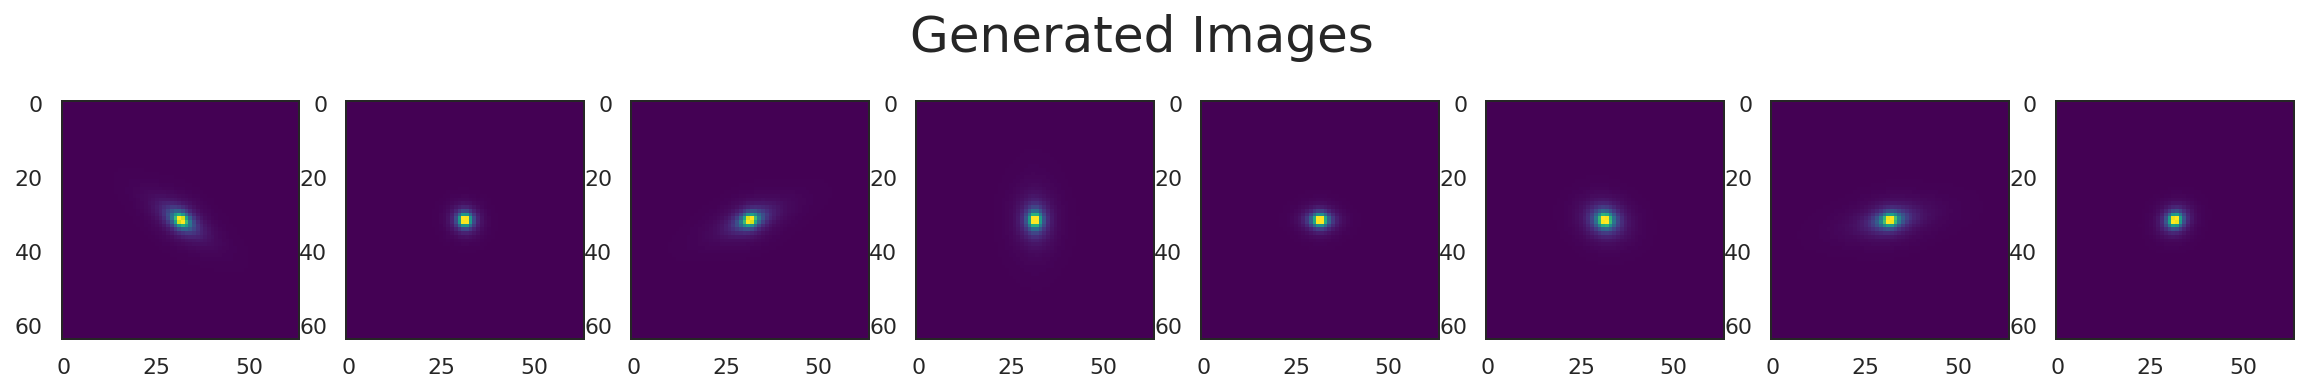

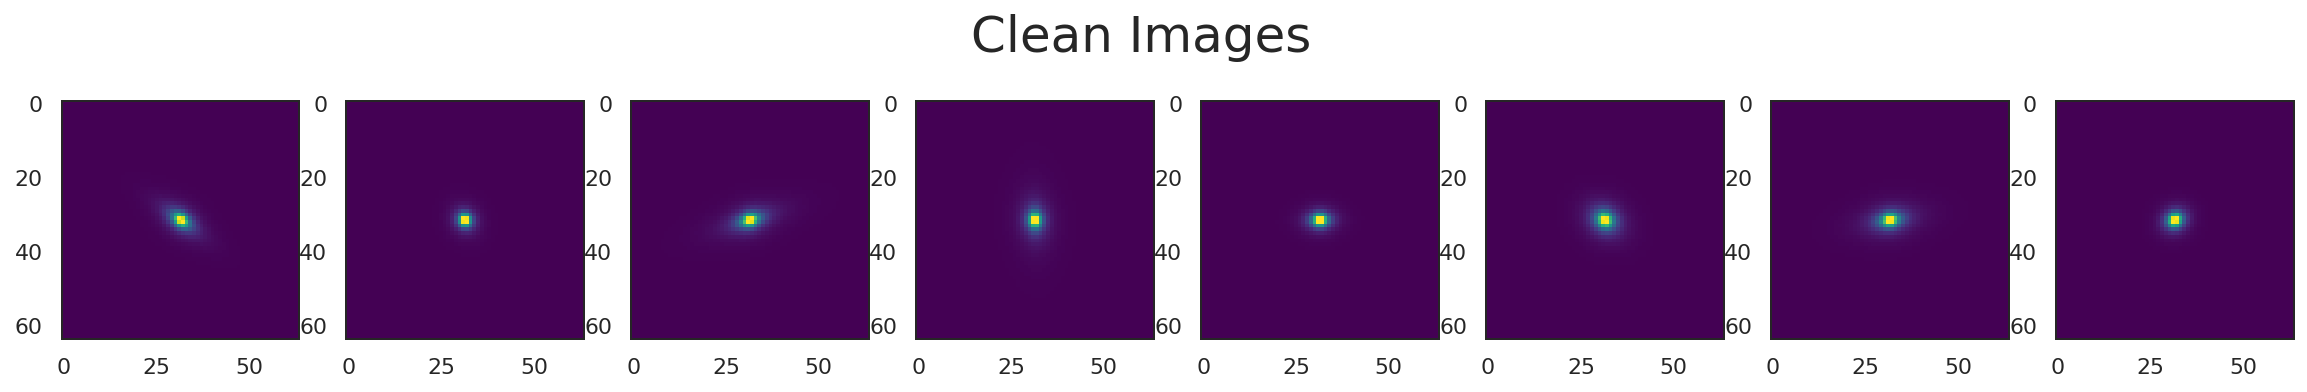

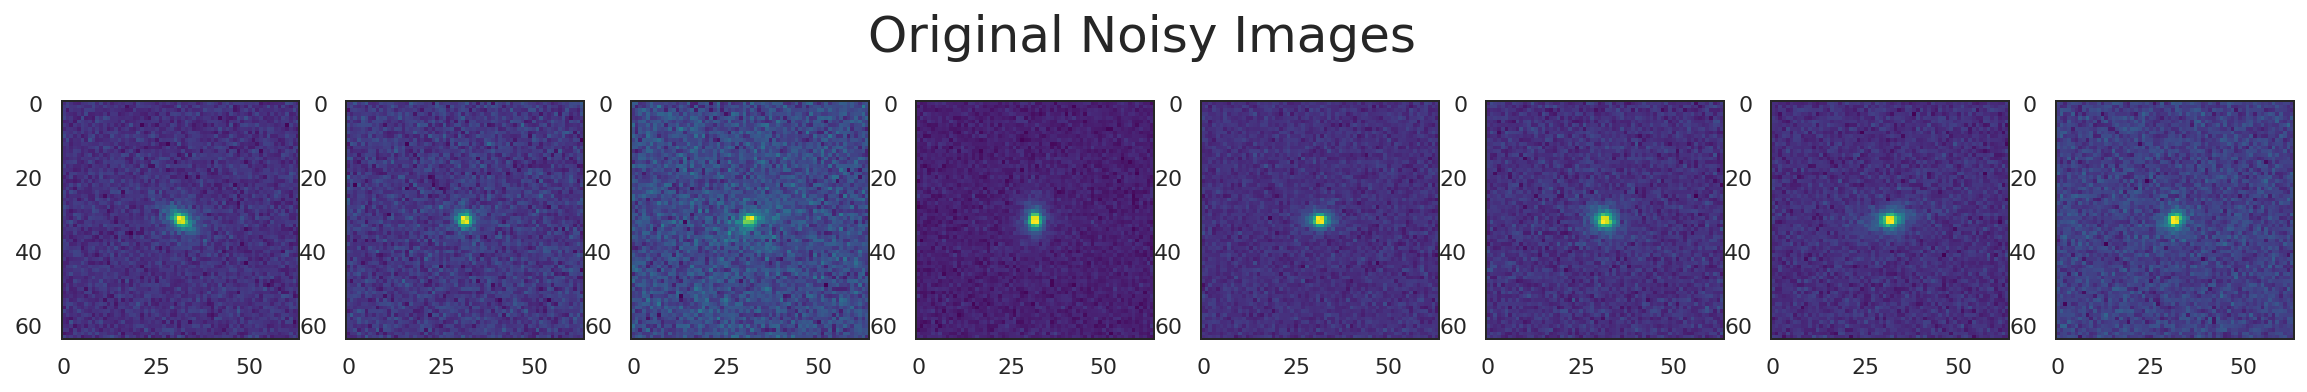

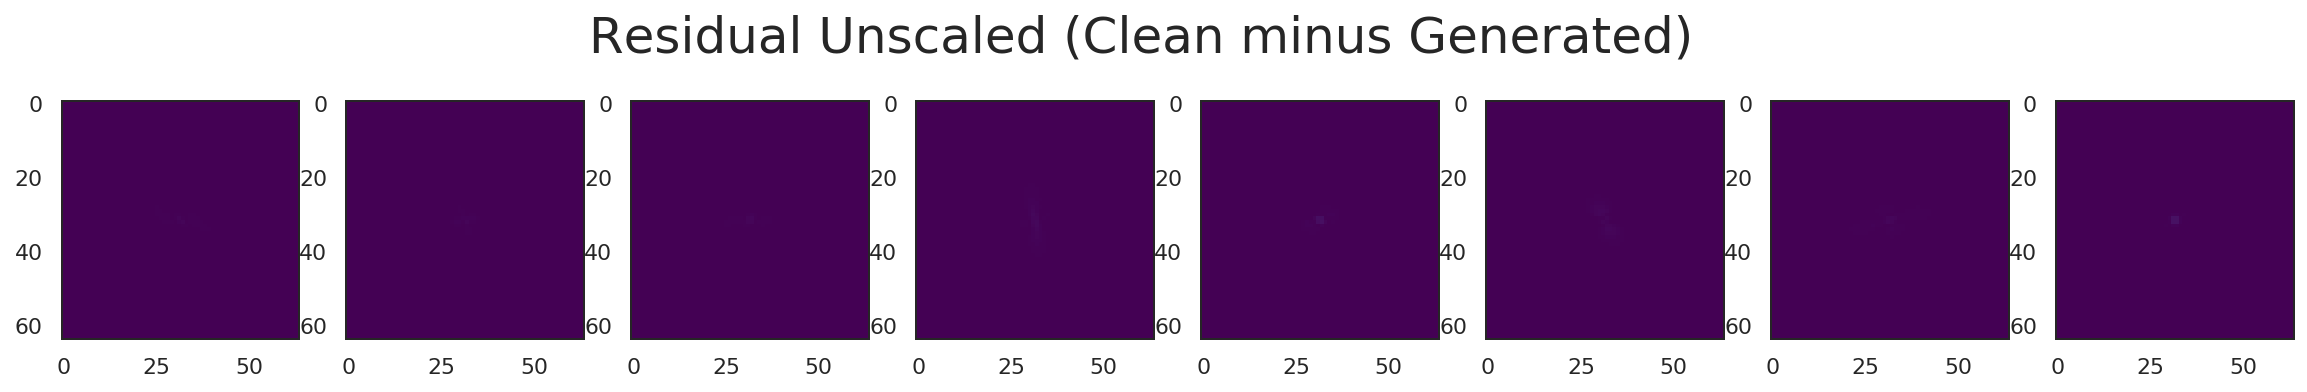

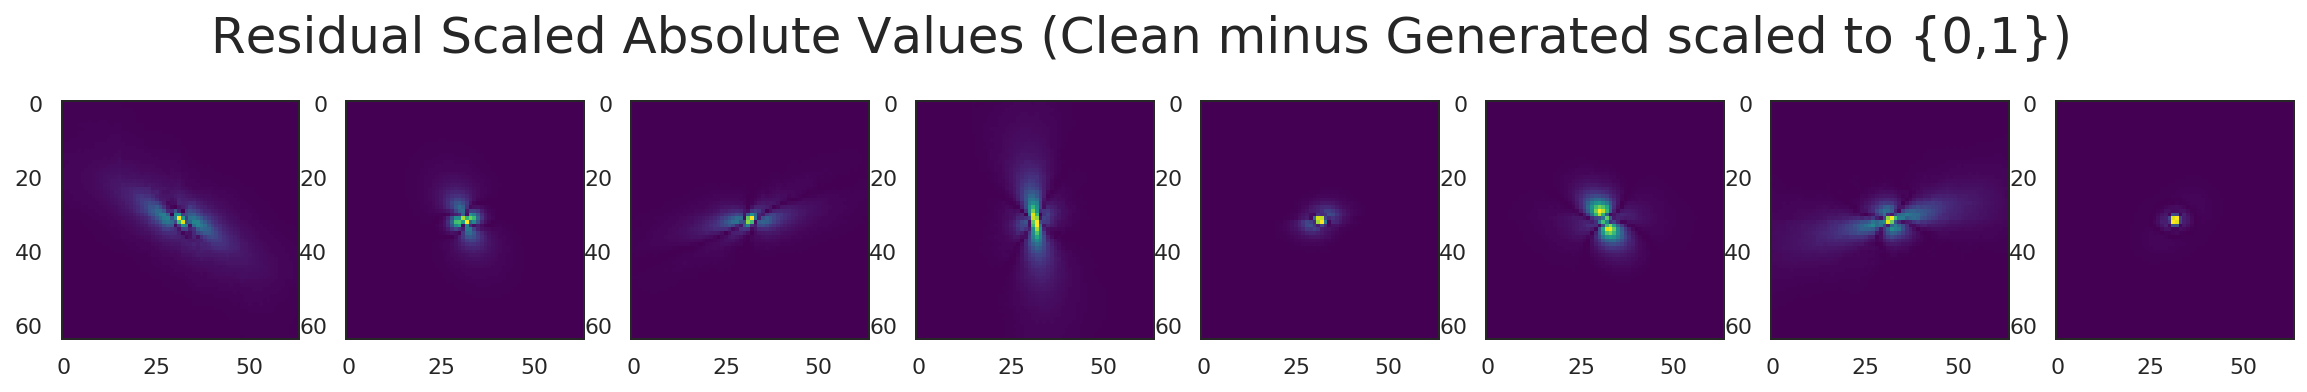

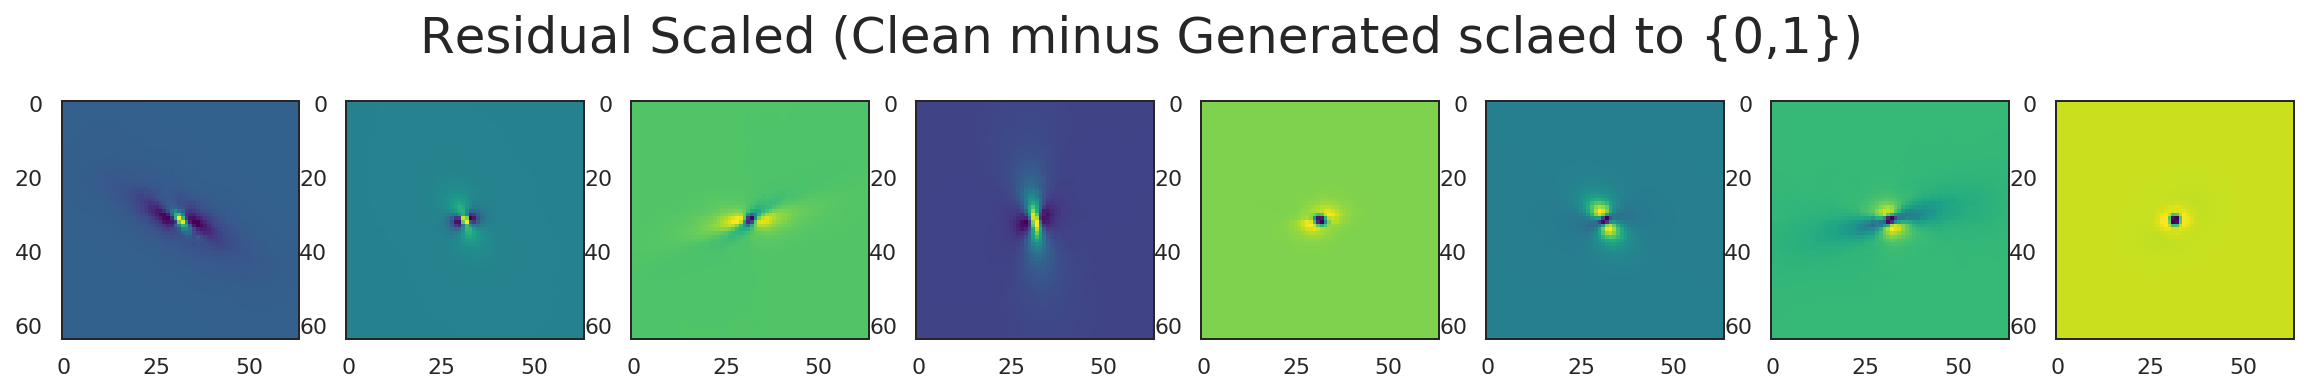

In [28]:
generate_images(CAE, val_ds_AE)

<div class='gc'> <b> Variance Analysis for Label </b> </div>

In [29]:
pred = variance_analysis(CAE, val_ds_AE, scaler_label1, label_val)

Bias         RMSE  Un-Explained Variance  \
Flux          -693.296326  5988.439453               0.015094   
Sersic Index     0.063714     0.778320               0.238936   
Sersic Radius   -0.003386     0.046738               0.110473   
g1               0.001007     0.073700               0.069717   
g2               0.011859     0.073978               0.071129   

               Explained Variance  
Flux                     0.984906  
Sersic Index             0.761064  
Sersic Radius            0.889527  
g1                       0.930283  
g2                       0.928871

<div class='gc'> <b> Comparing True Labels with Predicted Labels </b> </div>

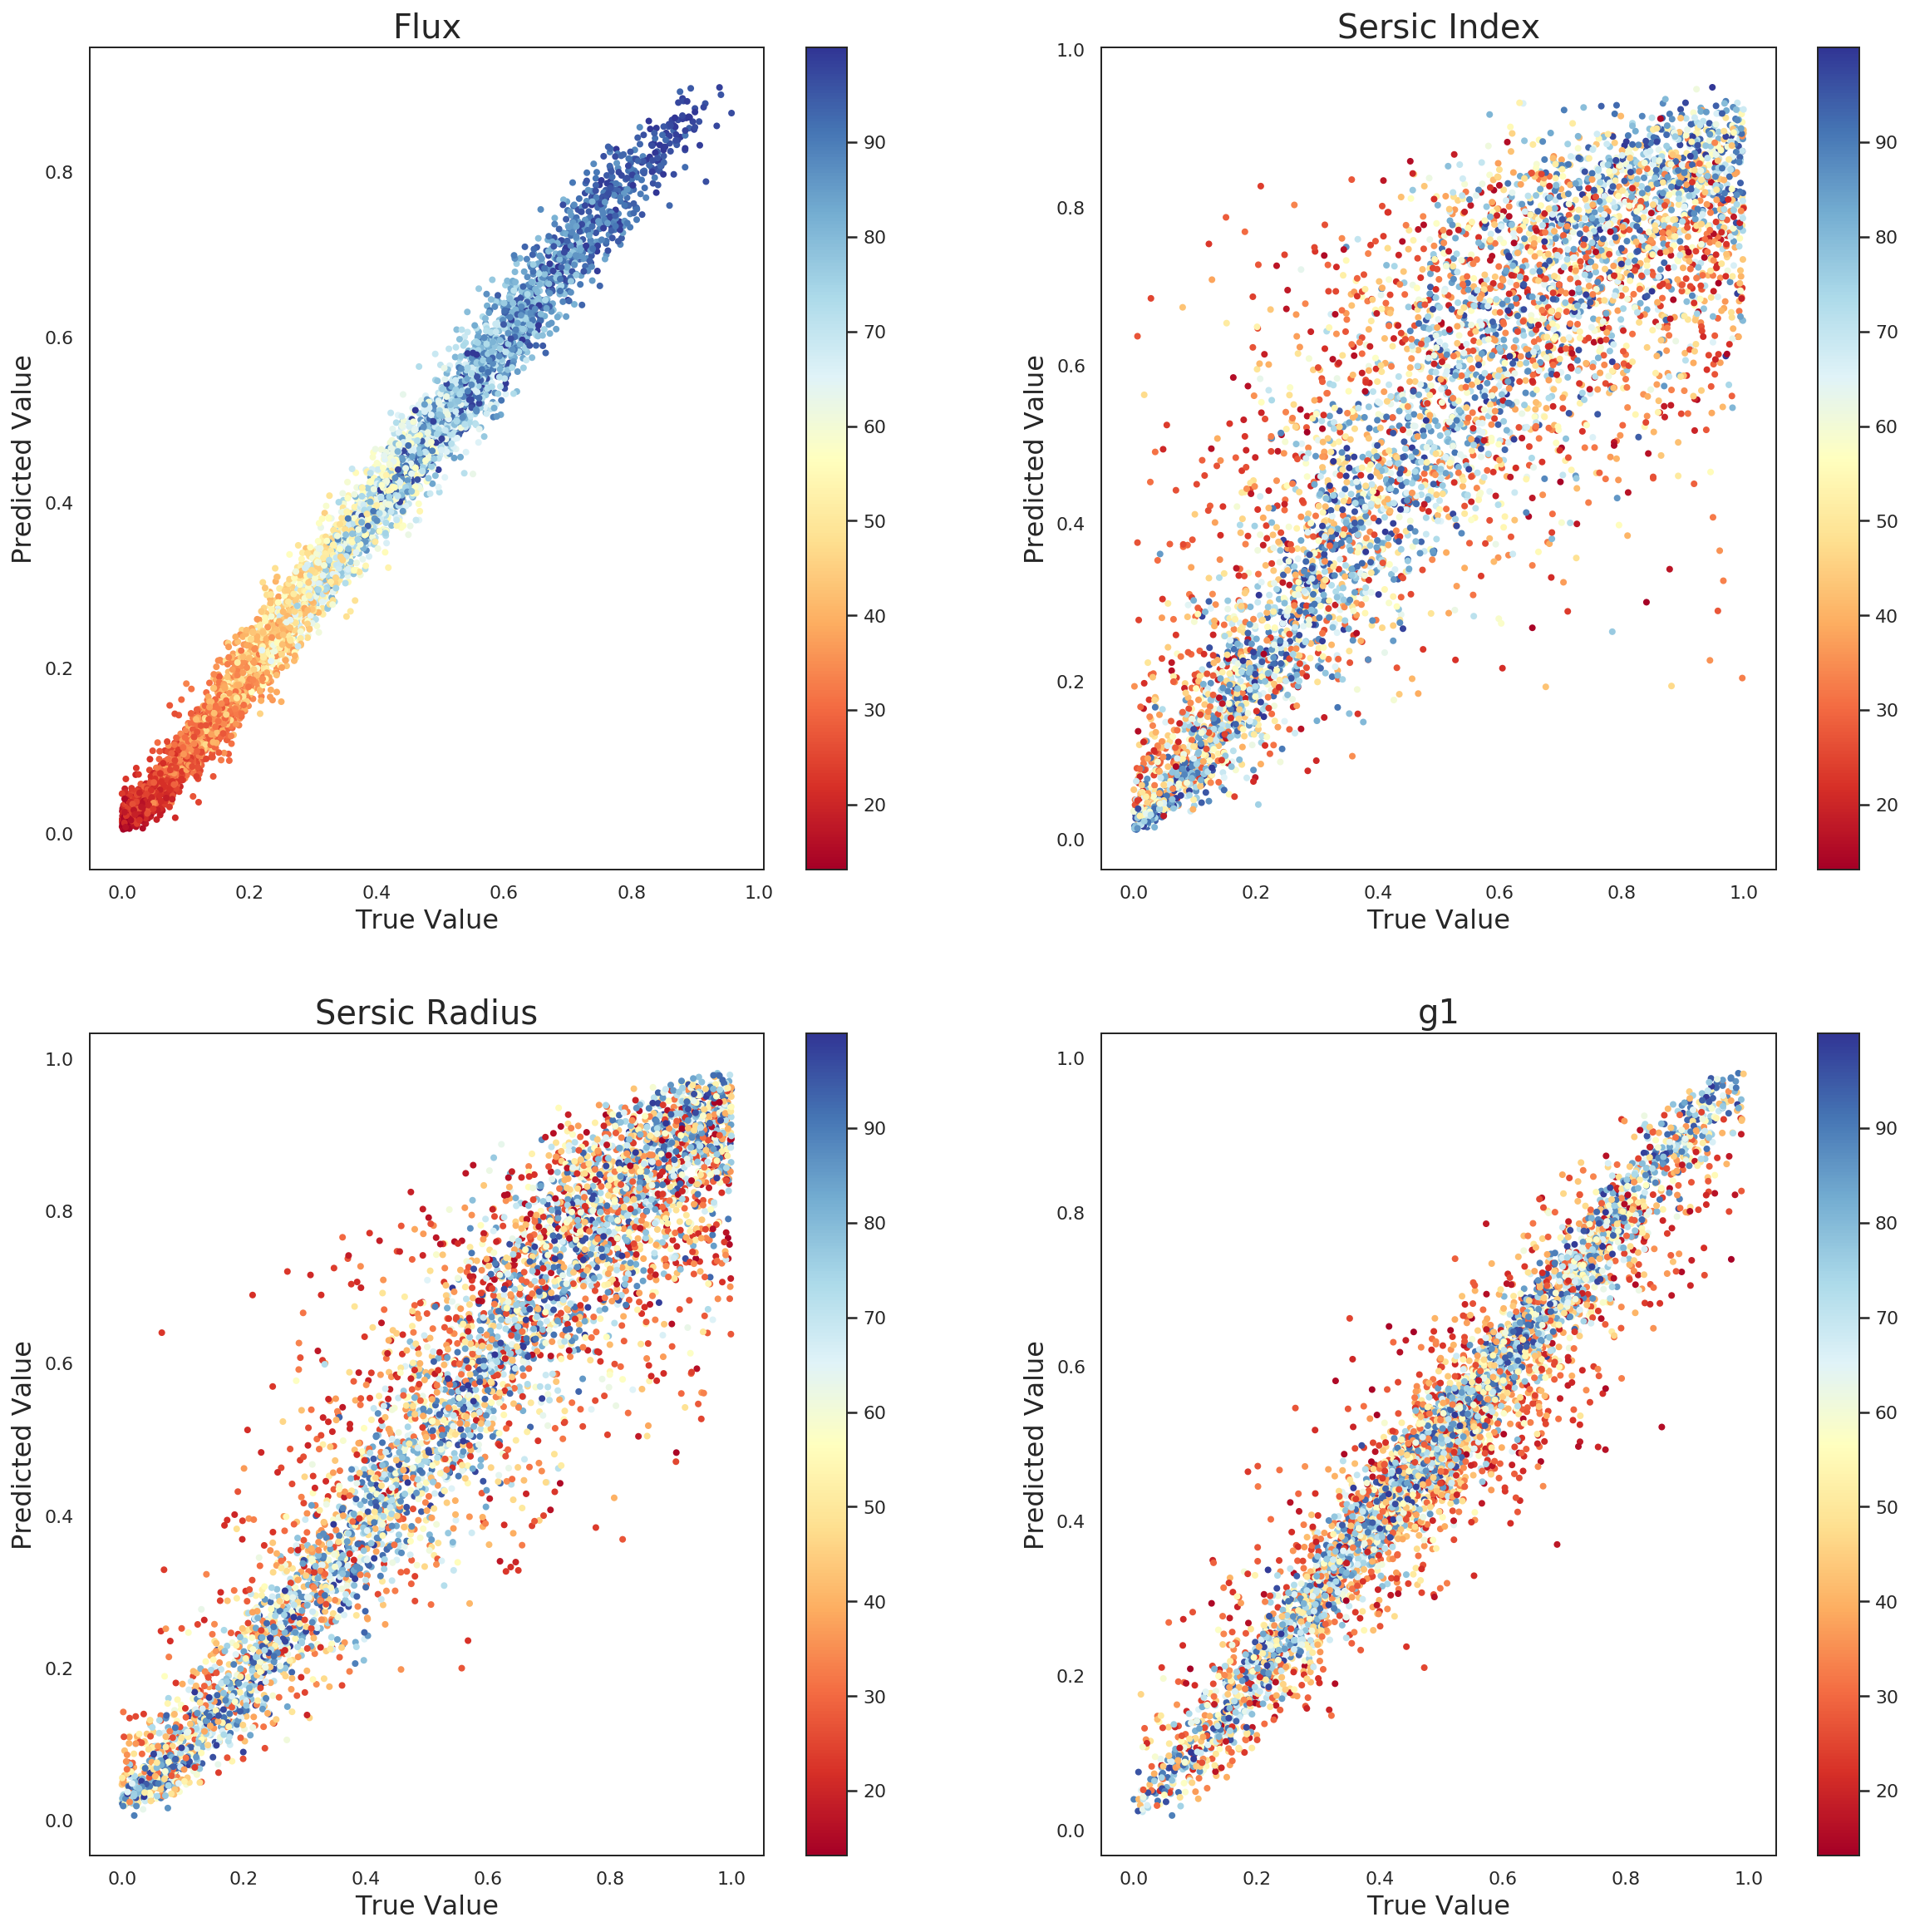

In [30]:
true_vs_pred(pred)

## <div class="theme"> End of Part 1 </div> 

## <div class="theme"> Part 2 </div> 

<div style="border: 3px solid #800080; padding: 10px"> 

## GalSim Images with variable Sigma and fixed PSF

### <div class='exercise'> <b> Step 1: Load the Training and Validation dataset with fixed noise and fixed PSF </b> </div>

In [31]:
# Read the data set
(image, 
 image_nonoise, 
 label, 
 snr) = load_data(set=2)


Available variables:
    img
    img_nonoise
    label
    psf_r
    snr
    sigma
    train_test

Image Shape            = (200000, 64, 64)
No-noise Image Shape   = (200000, 64, 64)
Label Shape            = (200000, 5)
SNR Shape              = (200000,)
Sigma Shape            = (200000,)
PSF-R Shape            = (200000,)


### <div class='exercise'> <b> Step 2: Split the data into Training and Validation, Normalize the data and Generate Image Pixel Statistics </b> </div>

In [32]:
(image_train, image_val,
 image_nonoise_train, image_nonoise_val,
 label_train, label_val,
 snr_train, snr_val,
 stats_train, stats_val,
 scaler_label2,
 scaler_image2,
 scaler_nonoise2) = normalize_and_split(image, image_nonoise, label, snr)


Number of Training Points:    180000
Number of Validation Points:  20000



### <div class='exercise'> <b> Step 3: Create Data Pipeline </b> </div>

<div class='gc'> <b> Function to Load Data and Divide data into Training and Validation Set </b> </div>

In [33]:
# Create Tensorflow Dataset
training, validation = create_dataset()

<div class='gc'> <b> Create dataset pipeline </b> </div>

In [34]:
(tr_ds, val_ds,
 tr_ds_en, val_ds_en,
 tr_ds_AE, val_ds_AE) = create_data_pipeline(training, validation)

### <div class='exercise'> <b> Step 4: Train Conditional Auto-encoder </b> </div>

In [35]:
train_CAE(CAE, set=2)

704/704 [==============================] - 140s 200ms/step - loss: 2.8372 - Decoder_loss: 0.0096 - Cond_Encoder_loss: 0.5655
Training Loss:   [2.8371621326289396, 0.009560162, 0.5655204]
79/79 [==============================] - 16s 198ms/step - loss: 2.8388 - Decoder_loss: 0.0096 - Cond_Encoder_loss: 0.5658
Validation Loss: [2.8387944064562833, 0.0095521435, 0.56584835]


### <div class='exercise'> <b> Step 5: Performance Analysis </b> </div>

<div class='gc'> <b> Generating reconstructed images for visual inspection </b> </div>

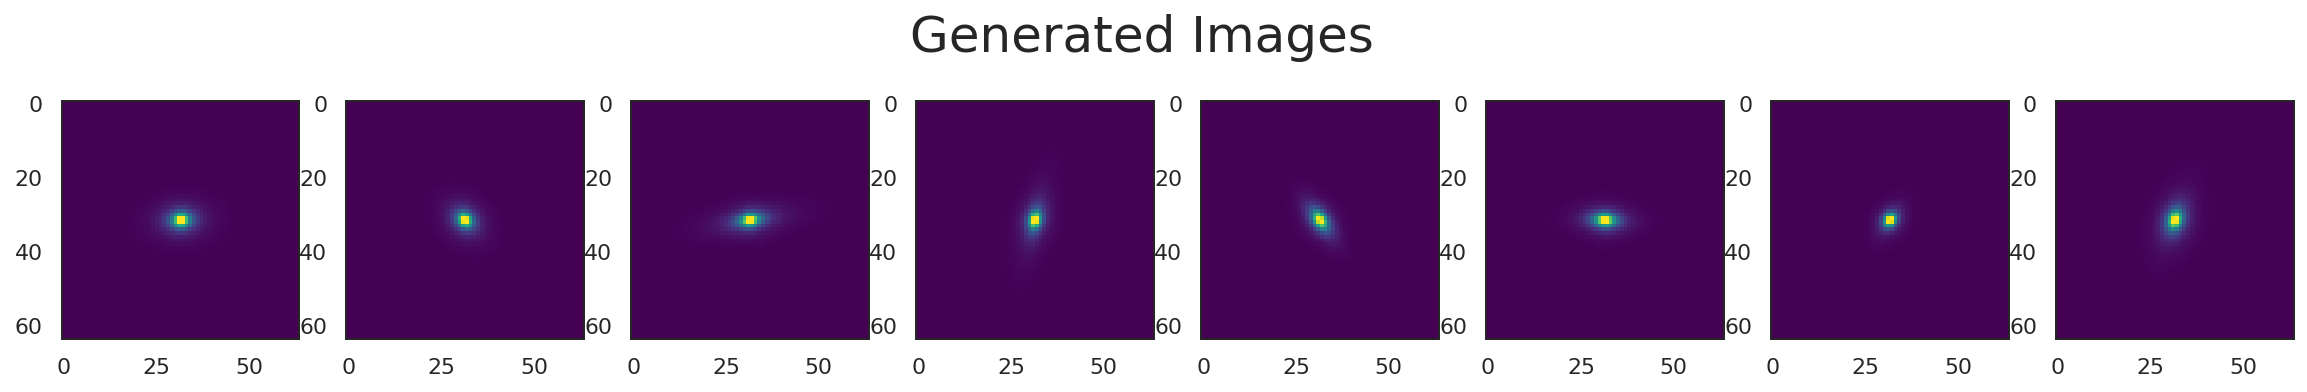

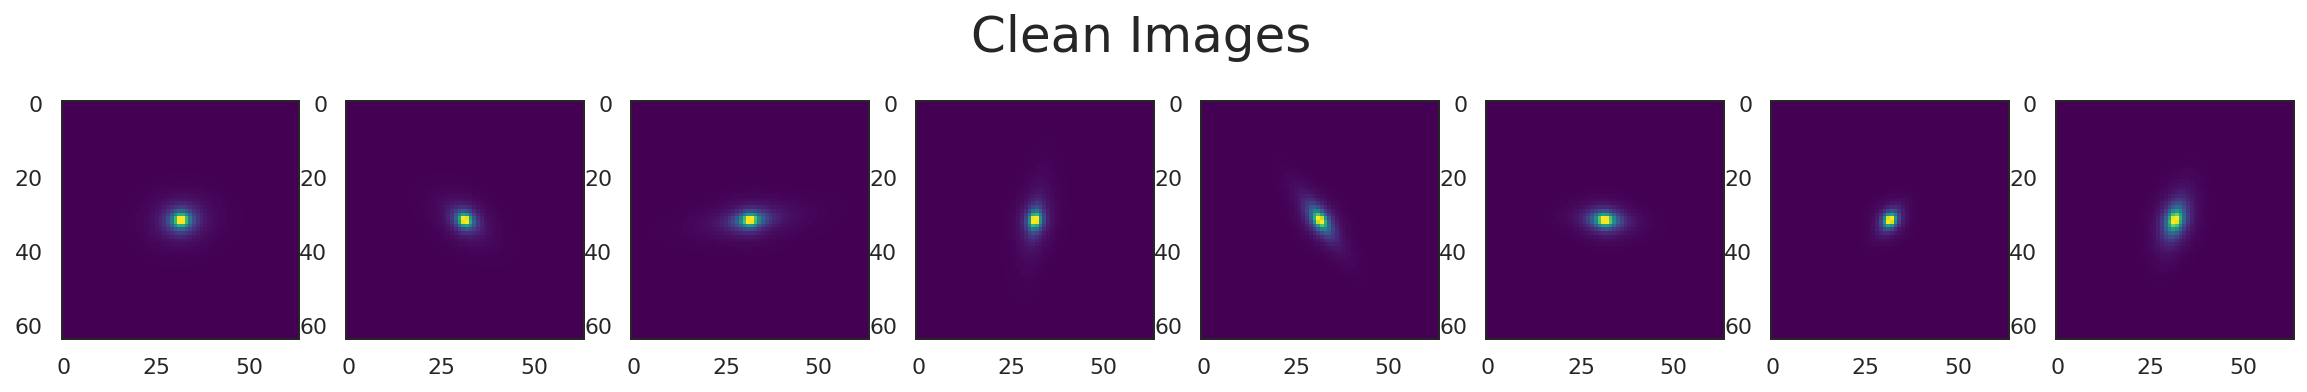

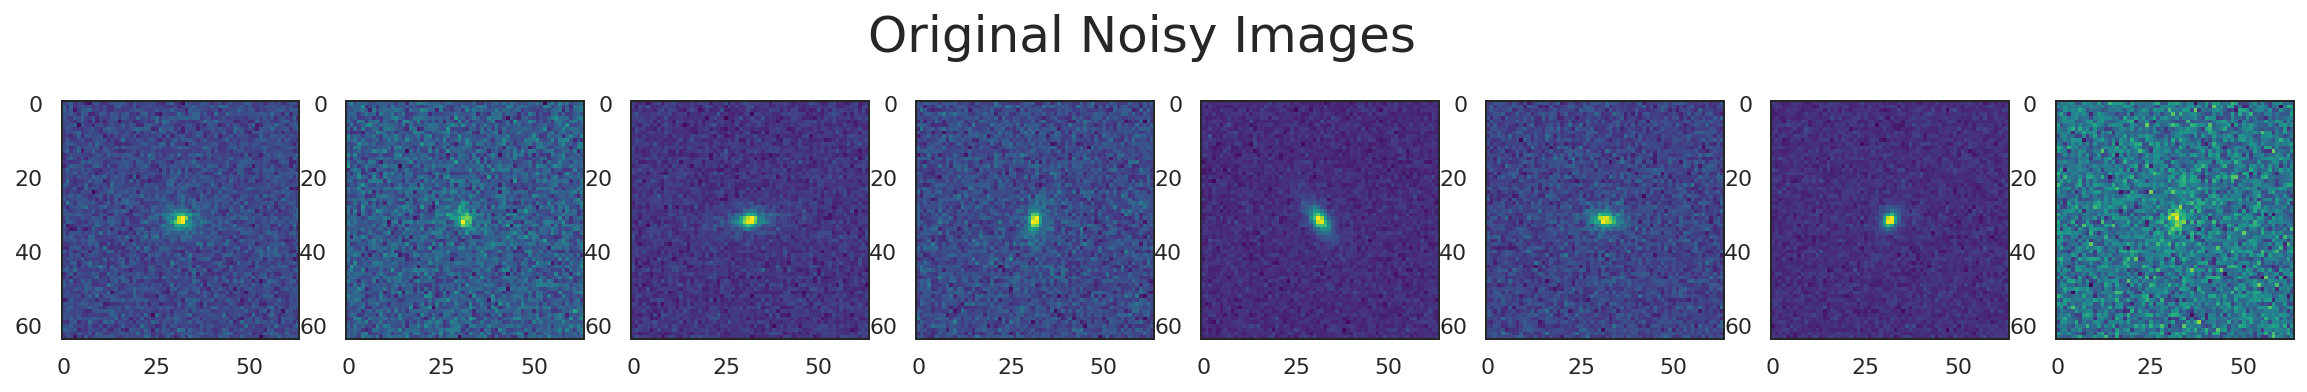

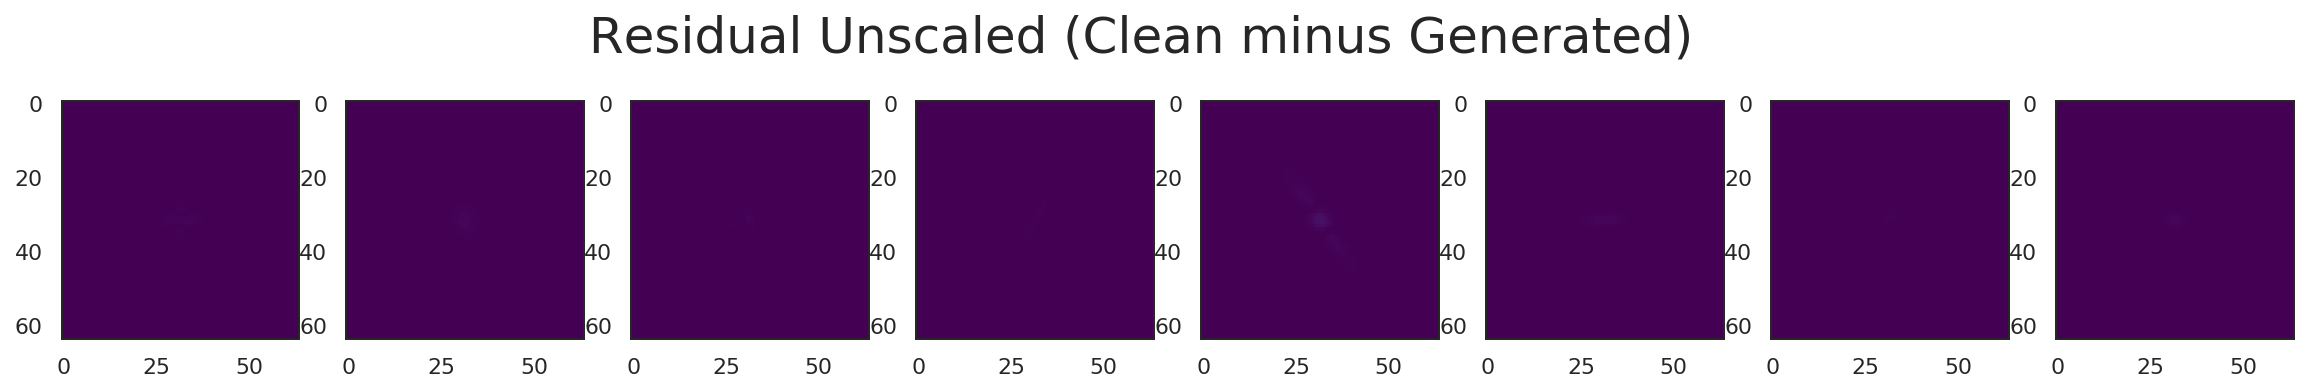

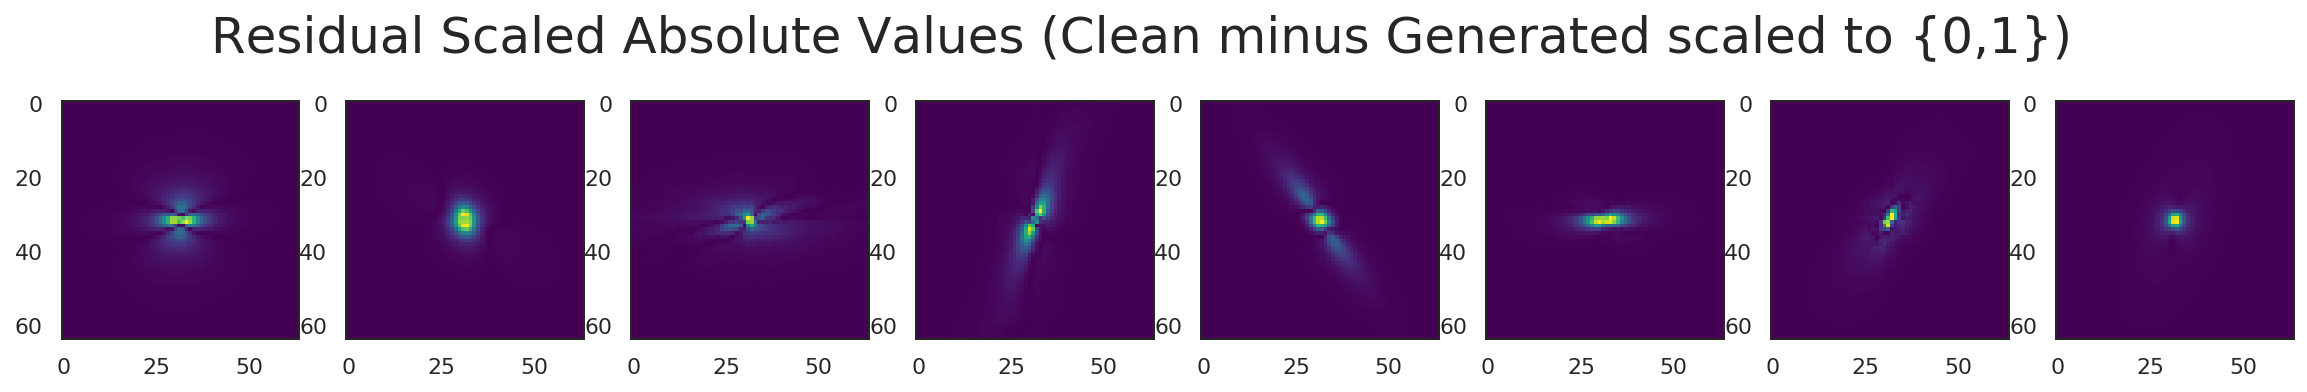

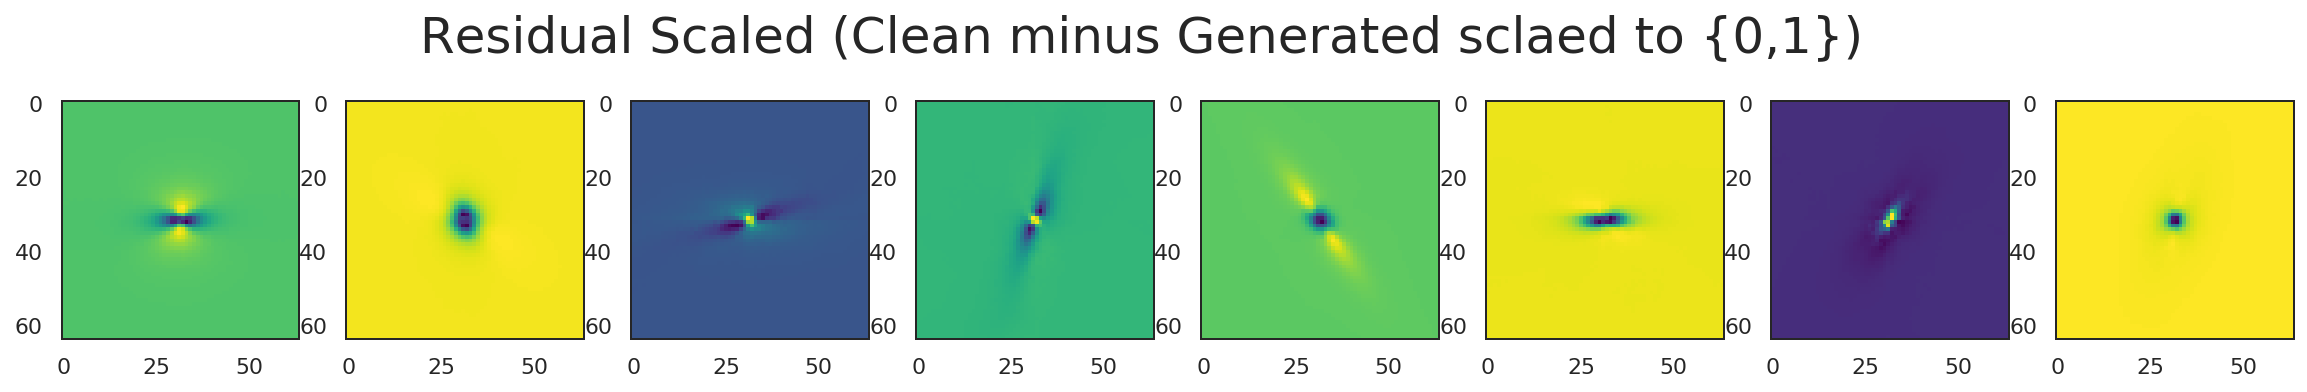

In [36]:
generate_images(CAE, val_ds_AE)

<div class='gc'> <b> Variance Analysis for Label </b> </div>

In [37]:
pred = variance_analysis(CAE, val_ds_AE, scaler_label2, label_val)

Bias         RMSE  Un-Explained Variance  \
Flux          -173.777512  9123.123047               0.012572   
Sersic Index    -0.054339     0.838216               0.277127   
Sersic Radius   -0.005115     0.051221               0.132222   
g1               0.015960     0.085757               0.096102   
g2              -0.022451     0.087131               0.097501   

               Explained Variance  
Flux                     0.987428  
Sersic Index             0.722873  
Sersic Radius            0.867778  
g1                       0.903898  
g2                       0.902499

<div class='gc'> <b> Comparing True Labels with Predicted Labels </b> </div>

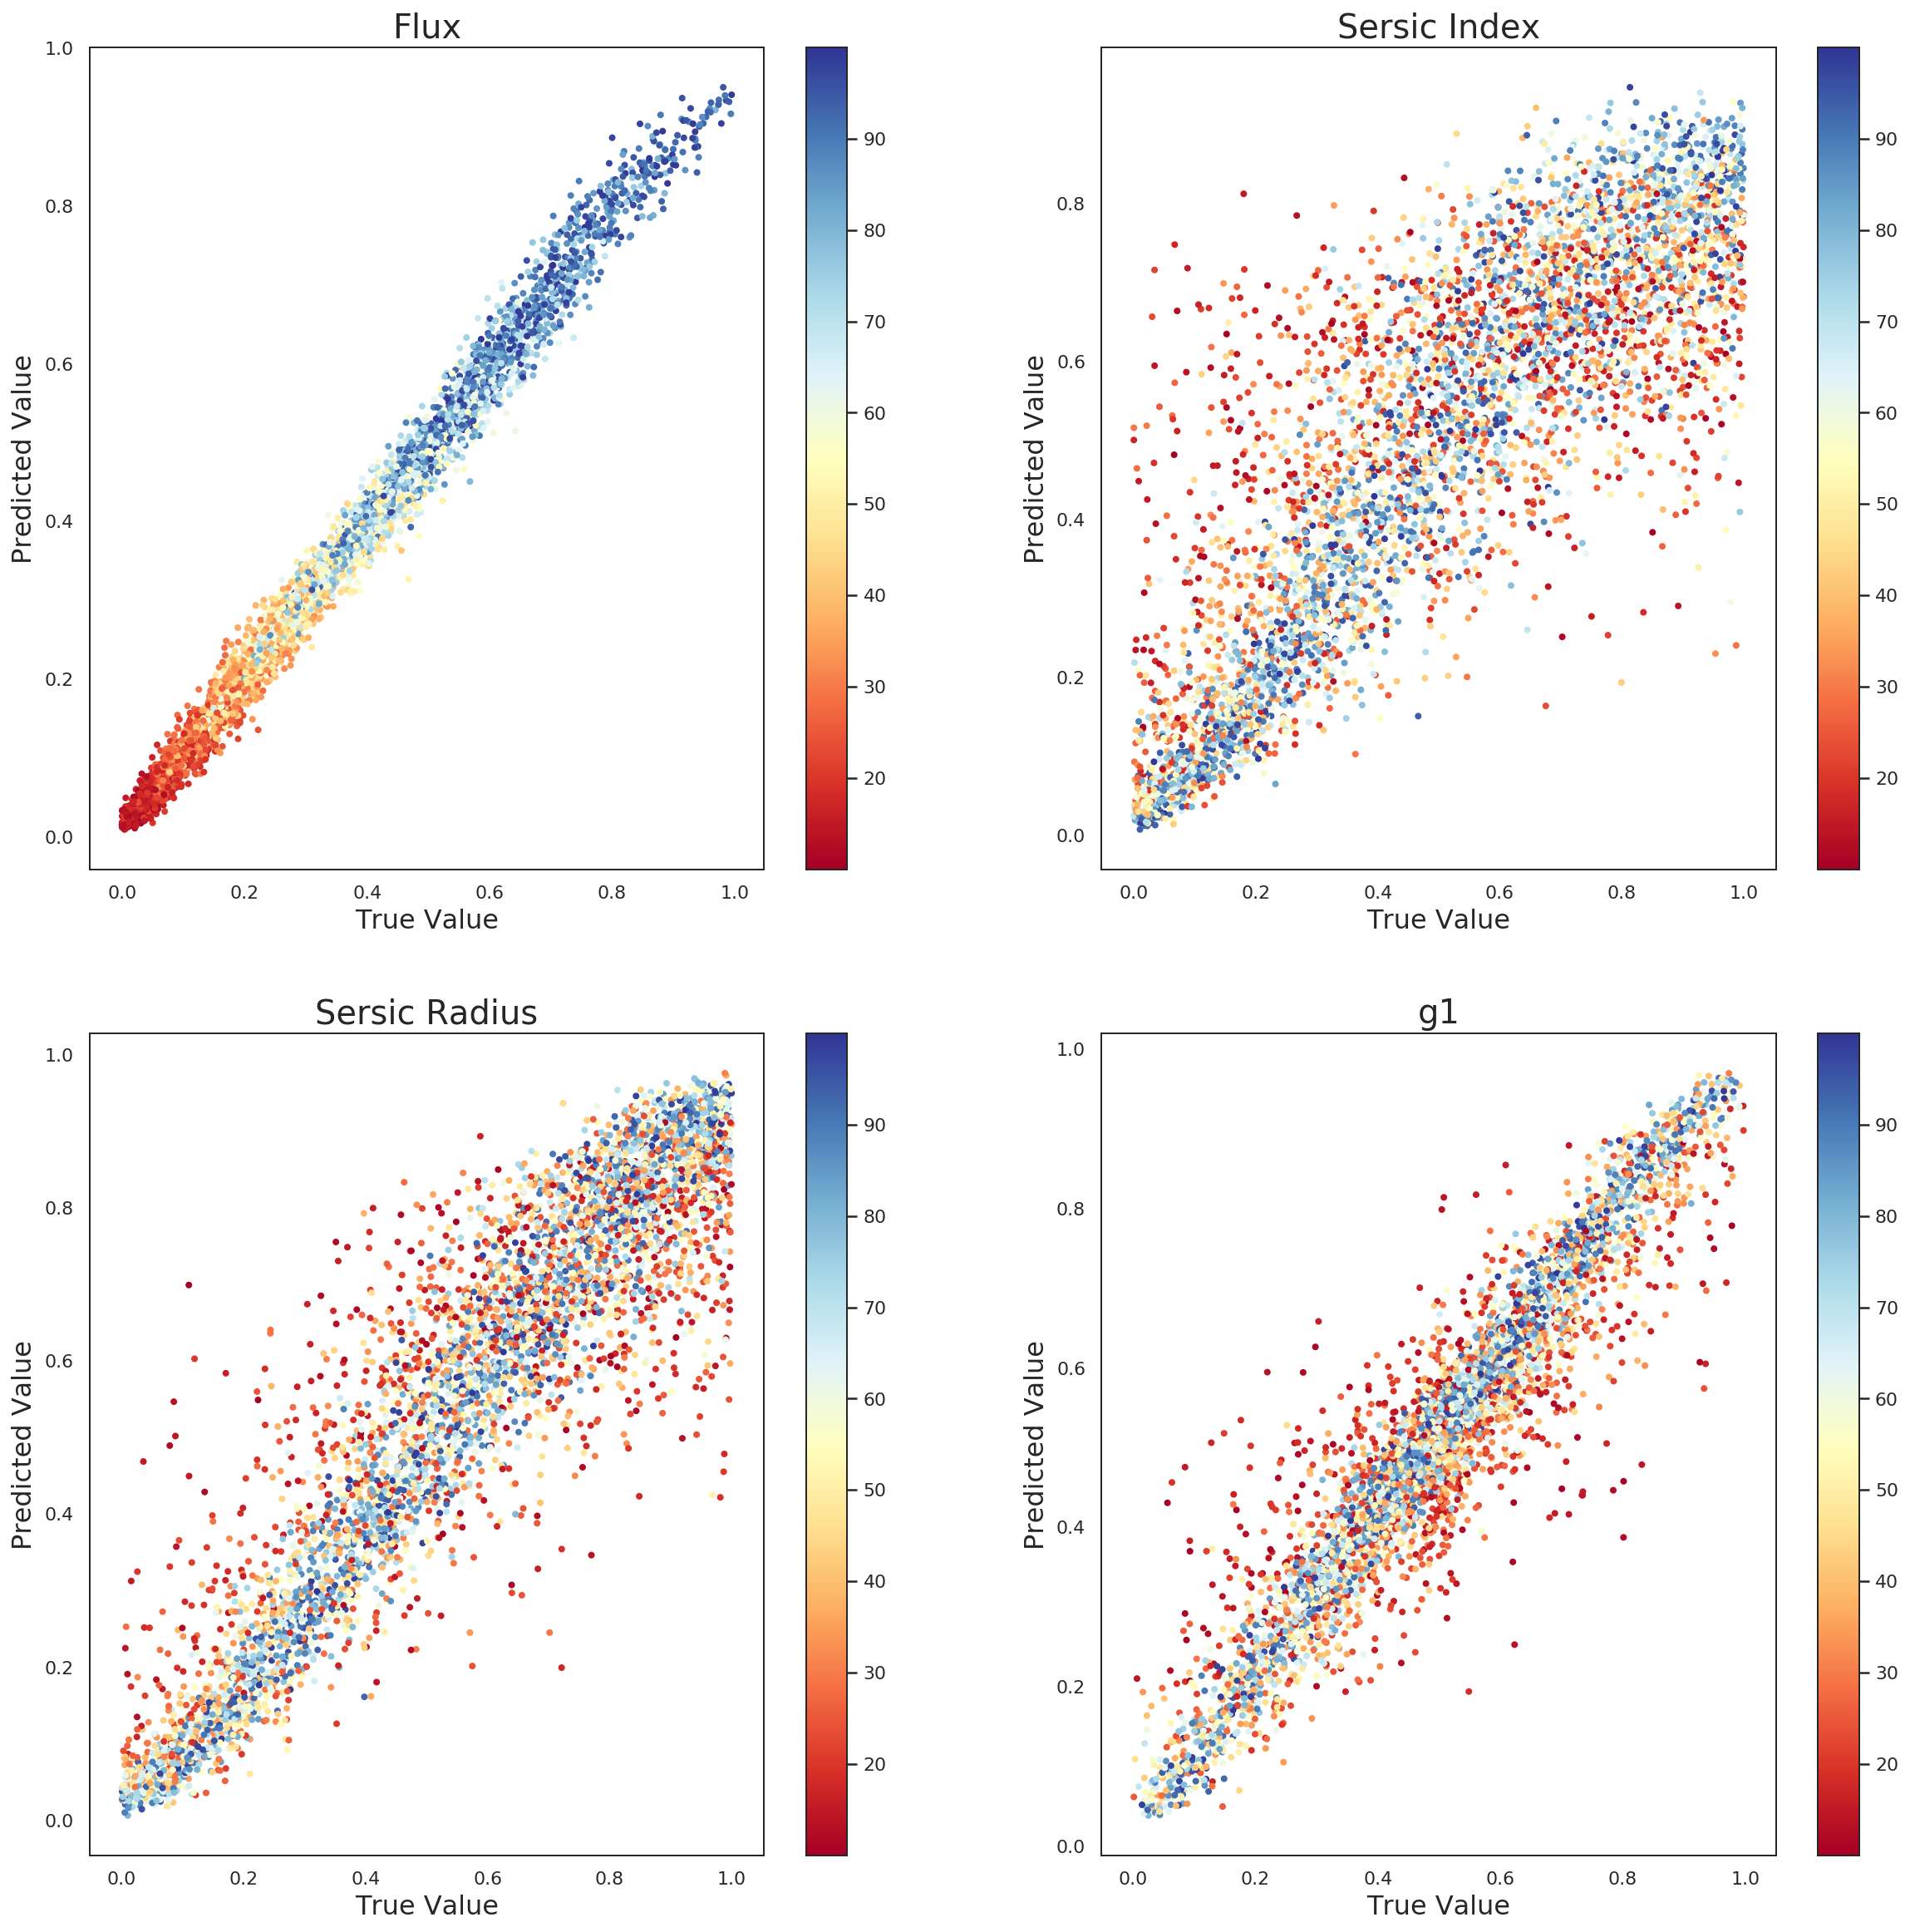

In [38]:
true_vs_pred(pred)

## <div class="theme"> End of Part 2 </div> 

## <div class="theme"> Part 3 </div> 

<div style="border: 3px solid #800080; padding: 10px"> 

## GalSim Images with variable Sigma and variable PSF

### <div class='exercise'> <b> Step 1: Load the Training and Validation dataset with fixed noise and fixed PSF </b> </div>

In [39]:
# Read the data set
(image, 
 image_nonoise, 
 label, 
 snr) = load_data(set=3)


Available variables:
    img
    img_nonoise
    label
    psf_r
    snr
    sigma

Image Shape            = (200000, 64, 64)
No-noise Image Shape   = (200000, 64, 64)
Label Shape            = (200000, 5)
SNR Shape              = (200000,)
Sigma Shape            = (200000,)
PSF-R Shape            = (200000,)


### <div class='exercise'> <b> Step 2: Split the data into Training and Validation, Normalize the data and Generate Image Pixel Statistics </b> </div>

In [40]:
(image_train, image_val,
 image_nonoise_train, image_nonoise_val,
 label_train, label_val,
 snr_train, snr_val,
 stats_train, stats_val,
 scaler_label3,
 scaler_image3,
 scaler_nonoise3) = normalize_and_split(image, image_nonoise, label, snr)


Number of Training Points:    180000
Number of Validation Points:  20000



### <div class='exercise'> <b> Step 3: Create Data Pipeline </b> </div>

<div class='gc'> <b> Function to Load Data and Divide data into Training and Validation Set </b> </div>

In [41]:
# Create Tensorflow Dataset
training, validation = create_dataset()

<div class='gc'> <b> Create dataset pipeline </b> </div>

In [42]:
(tr_ds, val_ds,
 tr_ds_en, val_ds_en,
 tr_ds_AE, val_ds_AE) = create_data_pipeline(training, validation)

### <div class='exercise'> <b> Step 4: Train Conditional Auto-encoder </b> </div>

In [43]:
train_CAE(CAE, set=3)

704/704 [==============================] - 141s 200ms/step - loss: 2.9588 - Decoder_loss: 0.0126 - Cond_Encoder_loss: 0.5892
Training Loss:   [2.958833723583005, 0.012620614, 0.58924264]
79/79 [==============================] - 16s 198ms/step - loss: 2.9631 - Decoder_loss: 0.0126 - Cond_Encoder_loss: 0.5901
Validation Loss: [2.963134047351306, 0.012570746, 0.59011275]


### <div class='exercise'> <b> Step 5: Performance Analysis </b> </div>

<div class='gc'> <b> Generating reconstructed images for visual inspection </b> </div>

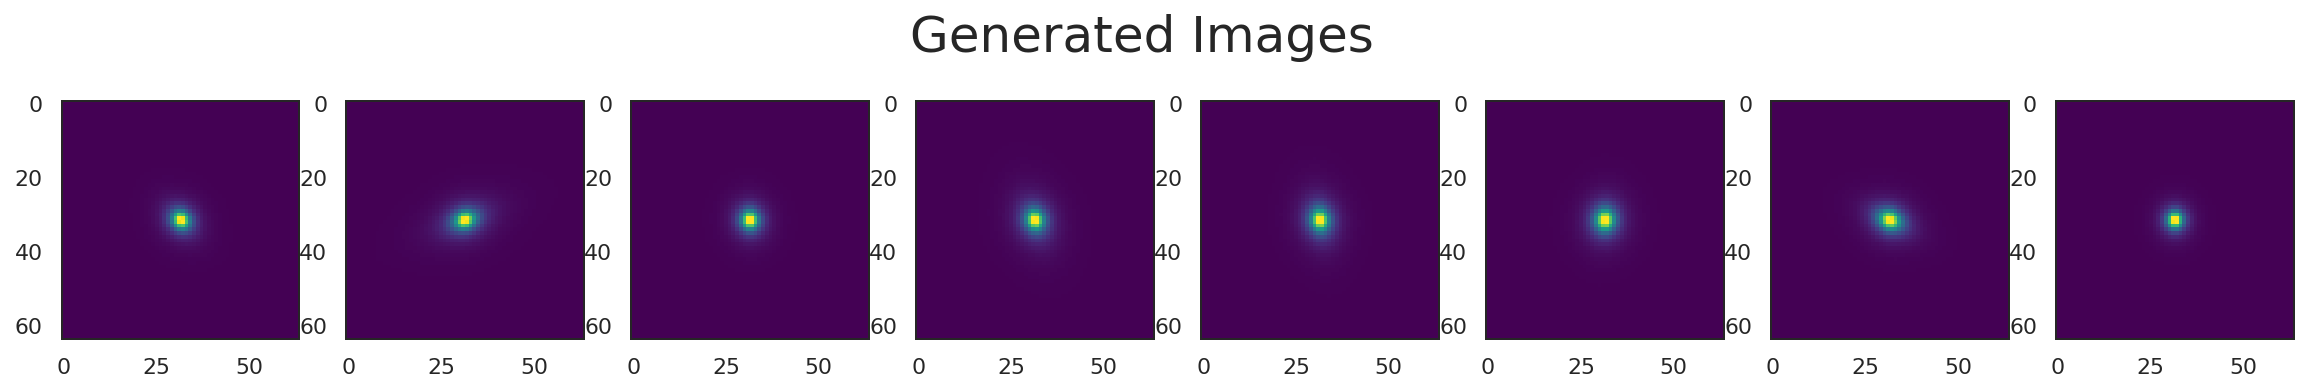

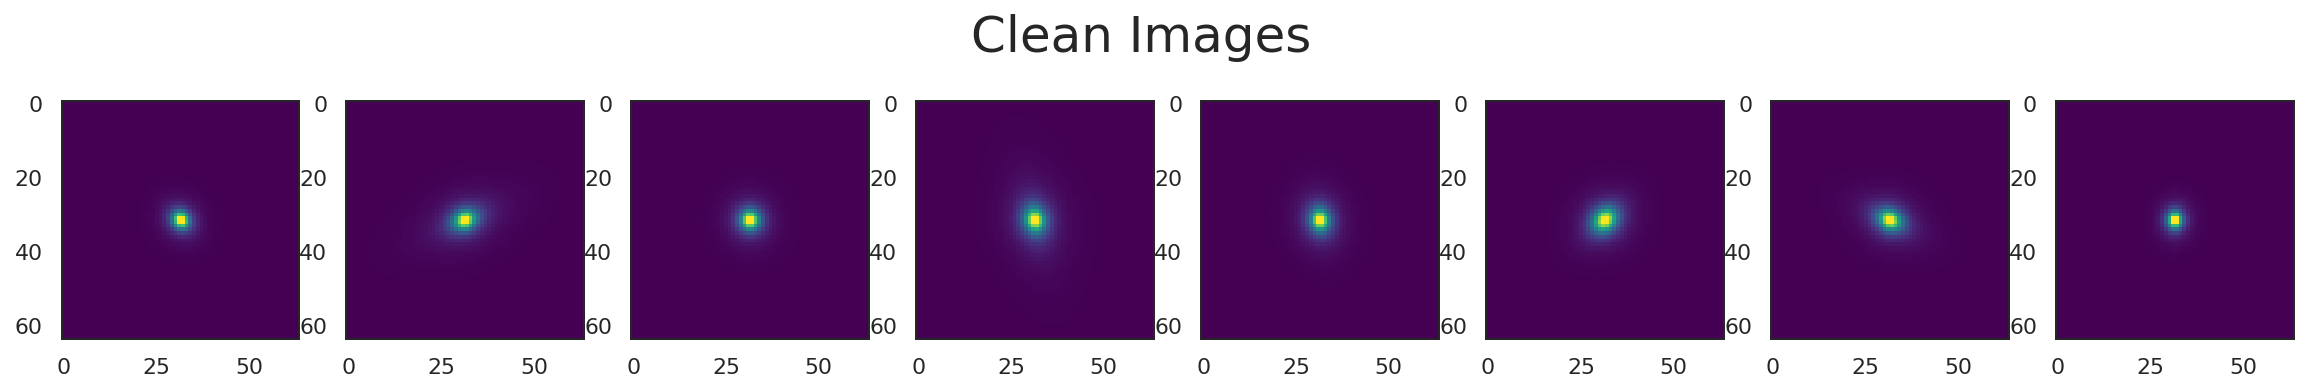

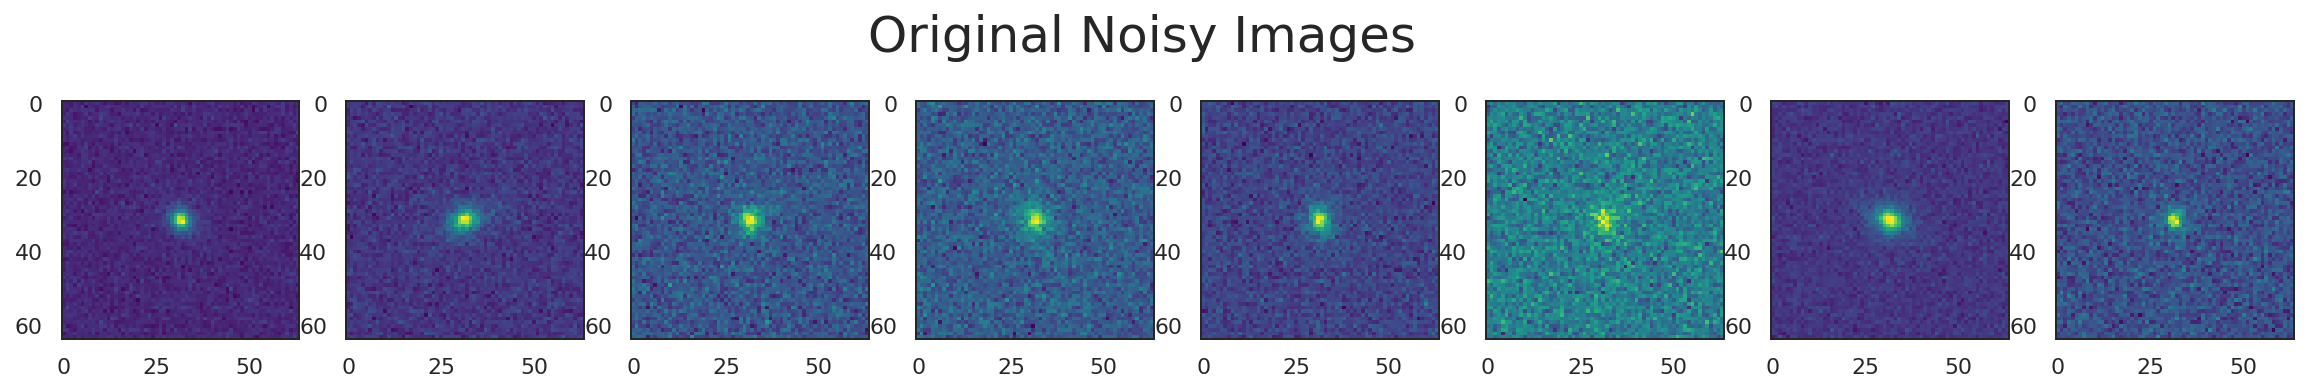

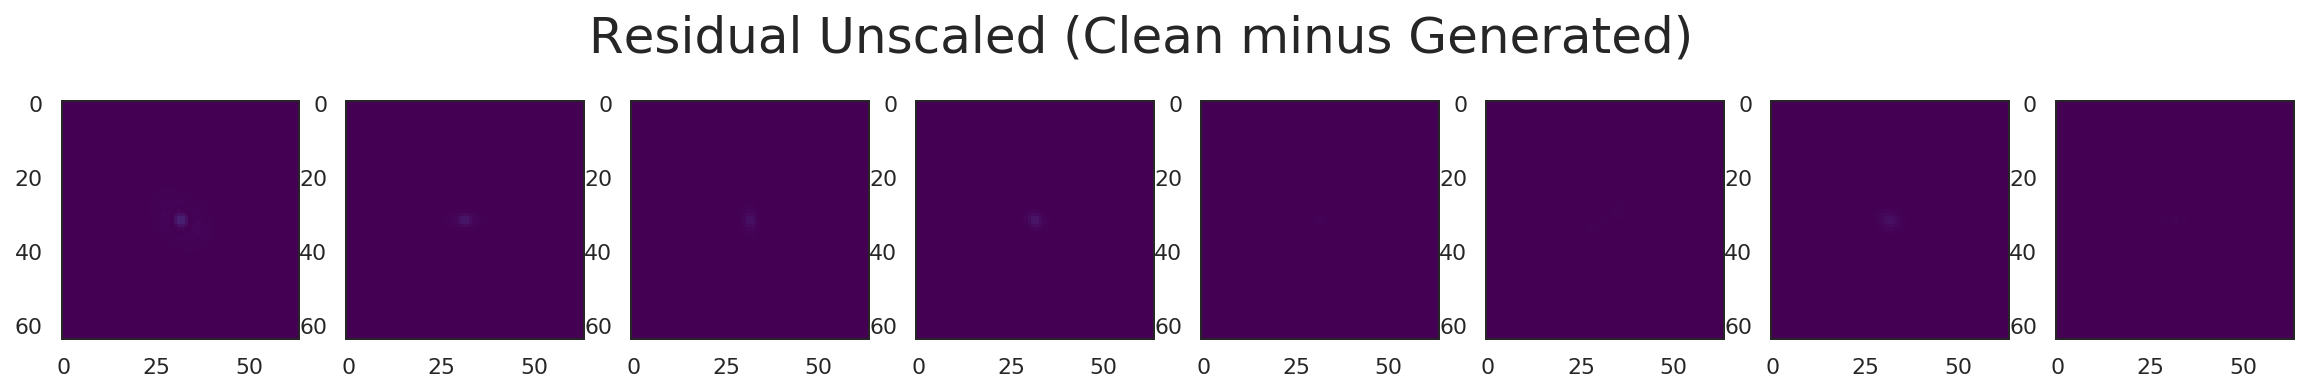

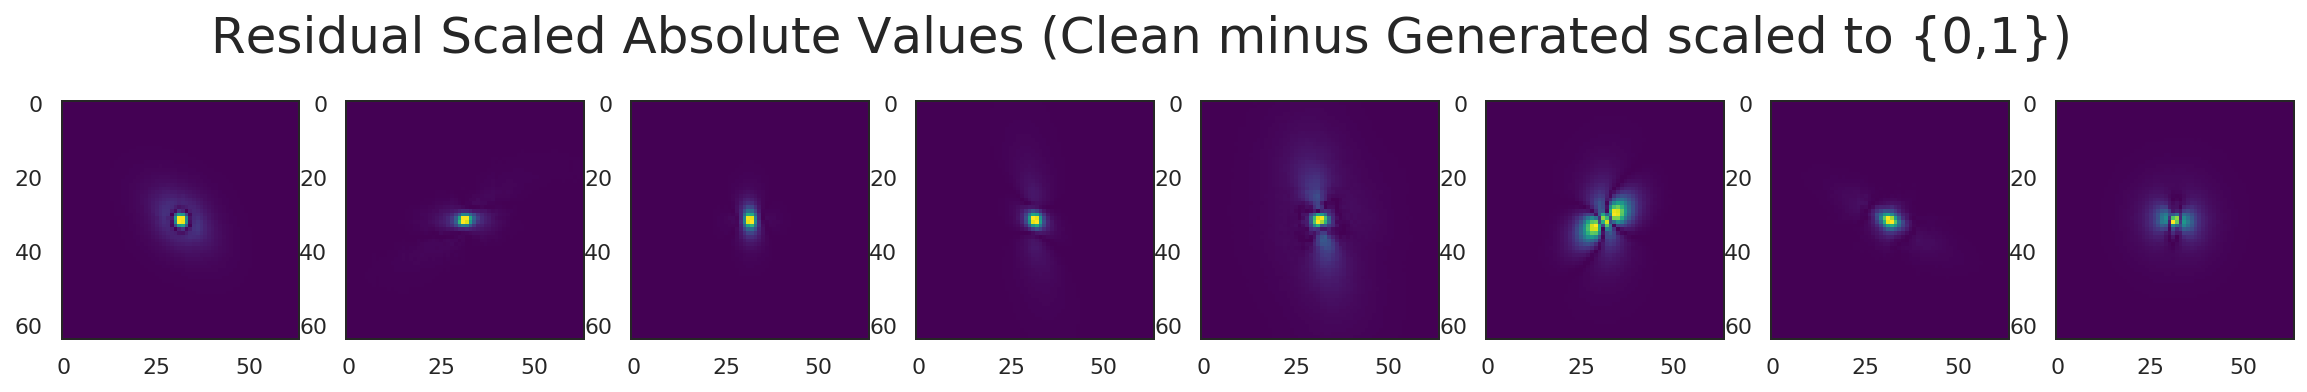

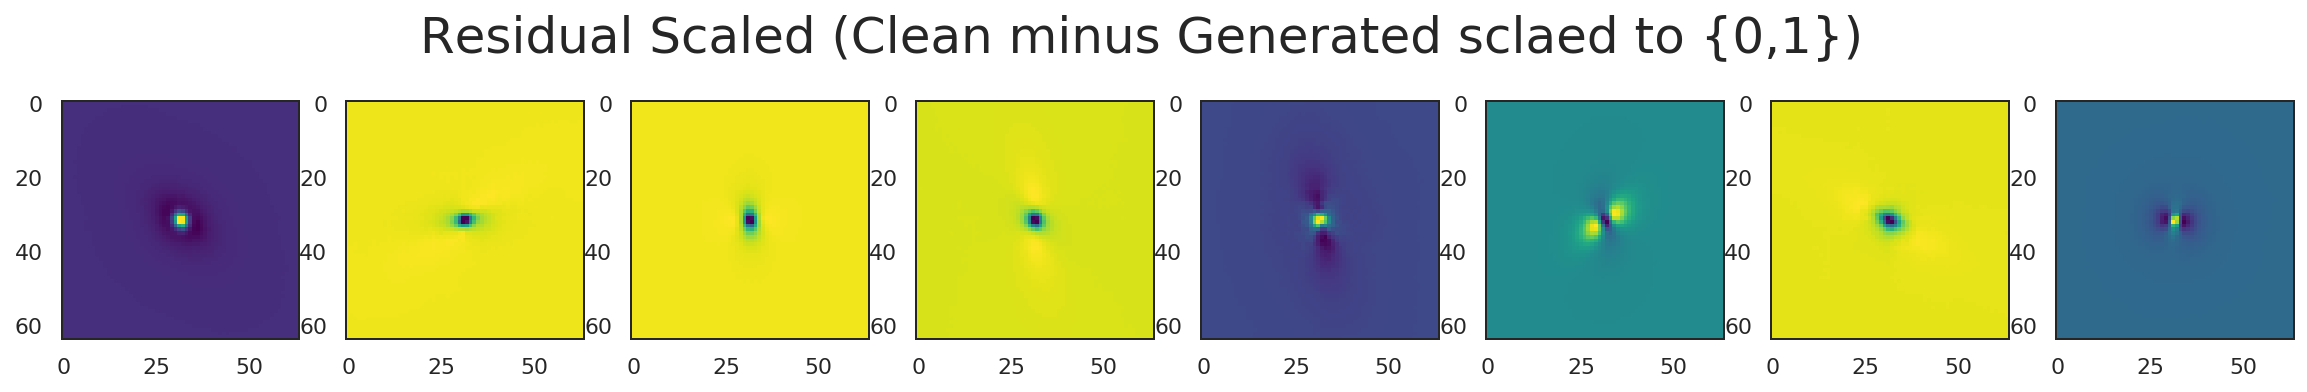

In [44]:
generate_images(CAE, val_ds_AE)

<div class='gc'> <b> Variance Analysis for Label </b> </div>

In [45]:
pred = variance_analysis(CAE, val_ds_AE, scaler_label3, label_val)

Bias          RMSE  Un-Explained Variance  \
Flux           2740.511230  10950.475586               0.013576   
Sersic Index      0.036187      1.075364               0.456118   
Sersic Radius    -0.003395      0.093285               0.431708   
g1               -0.005927      0.109818               0.159909   
g2               -0.009060      0.110692               0.161865   

               Explained Variance  
Flux                     0.986424  
Sersic Index             0.543882  
Sersic Radius            0.568292  
g1                       0.840091  
g2                       0.838135

<div class='gc'> <b> Comparing True Labels with Predicted Labels </b> </div>

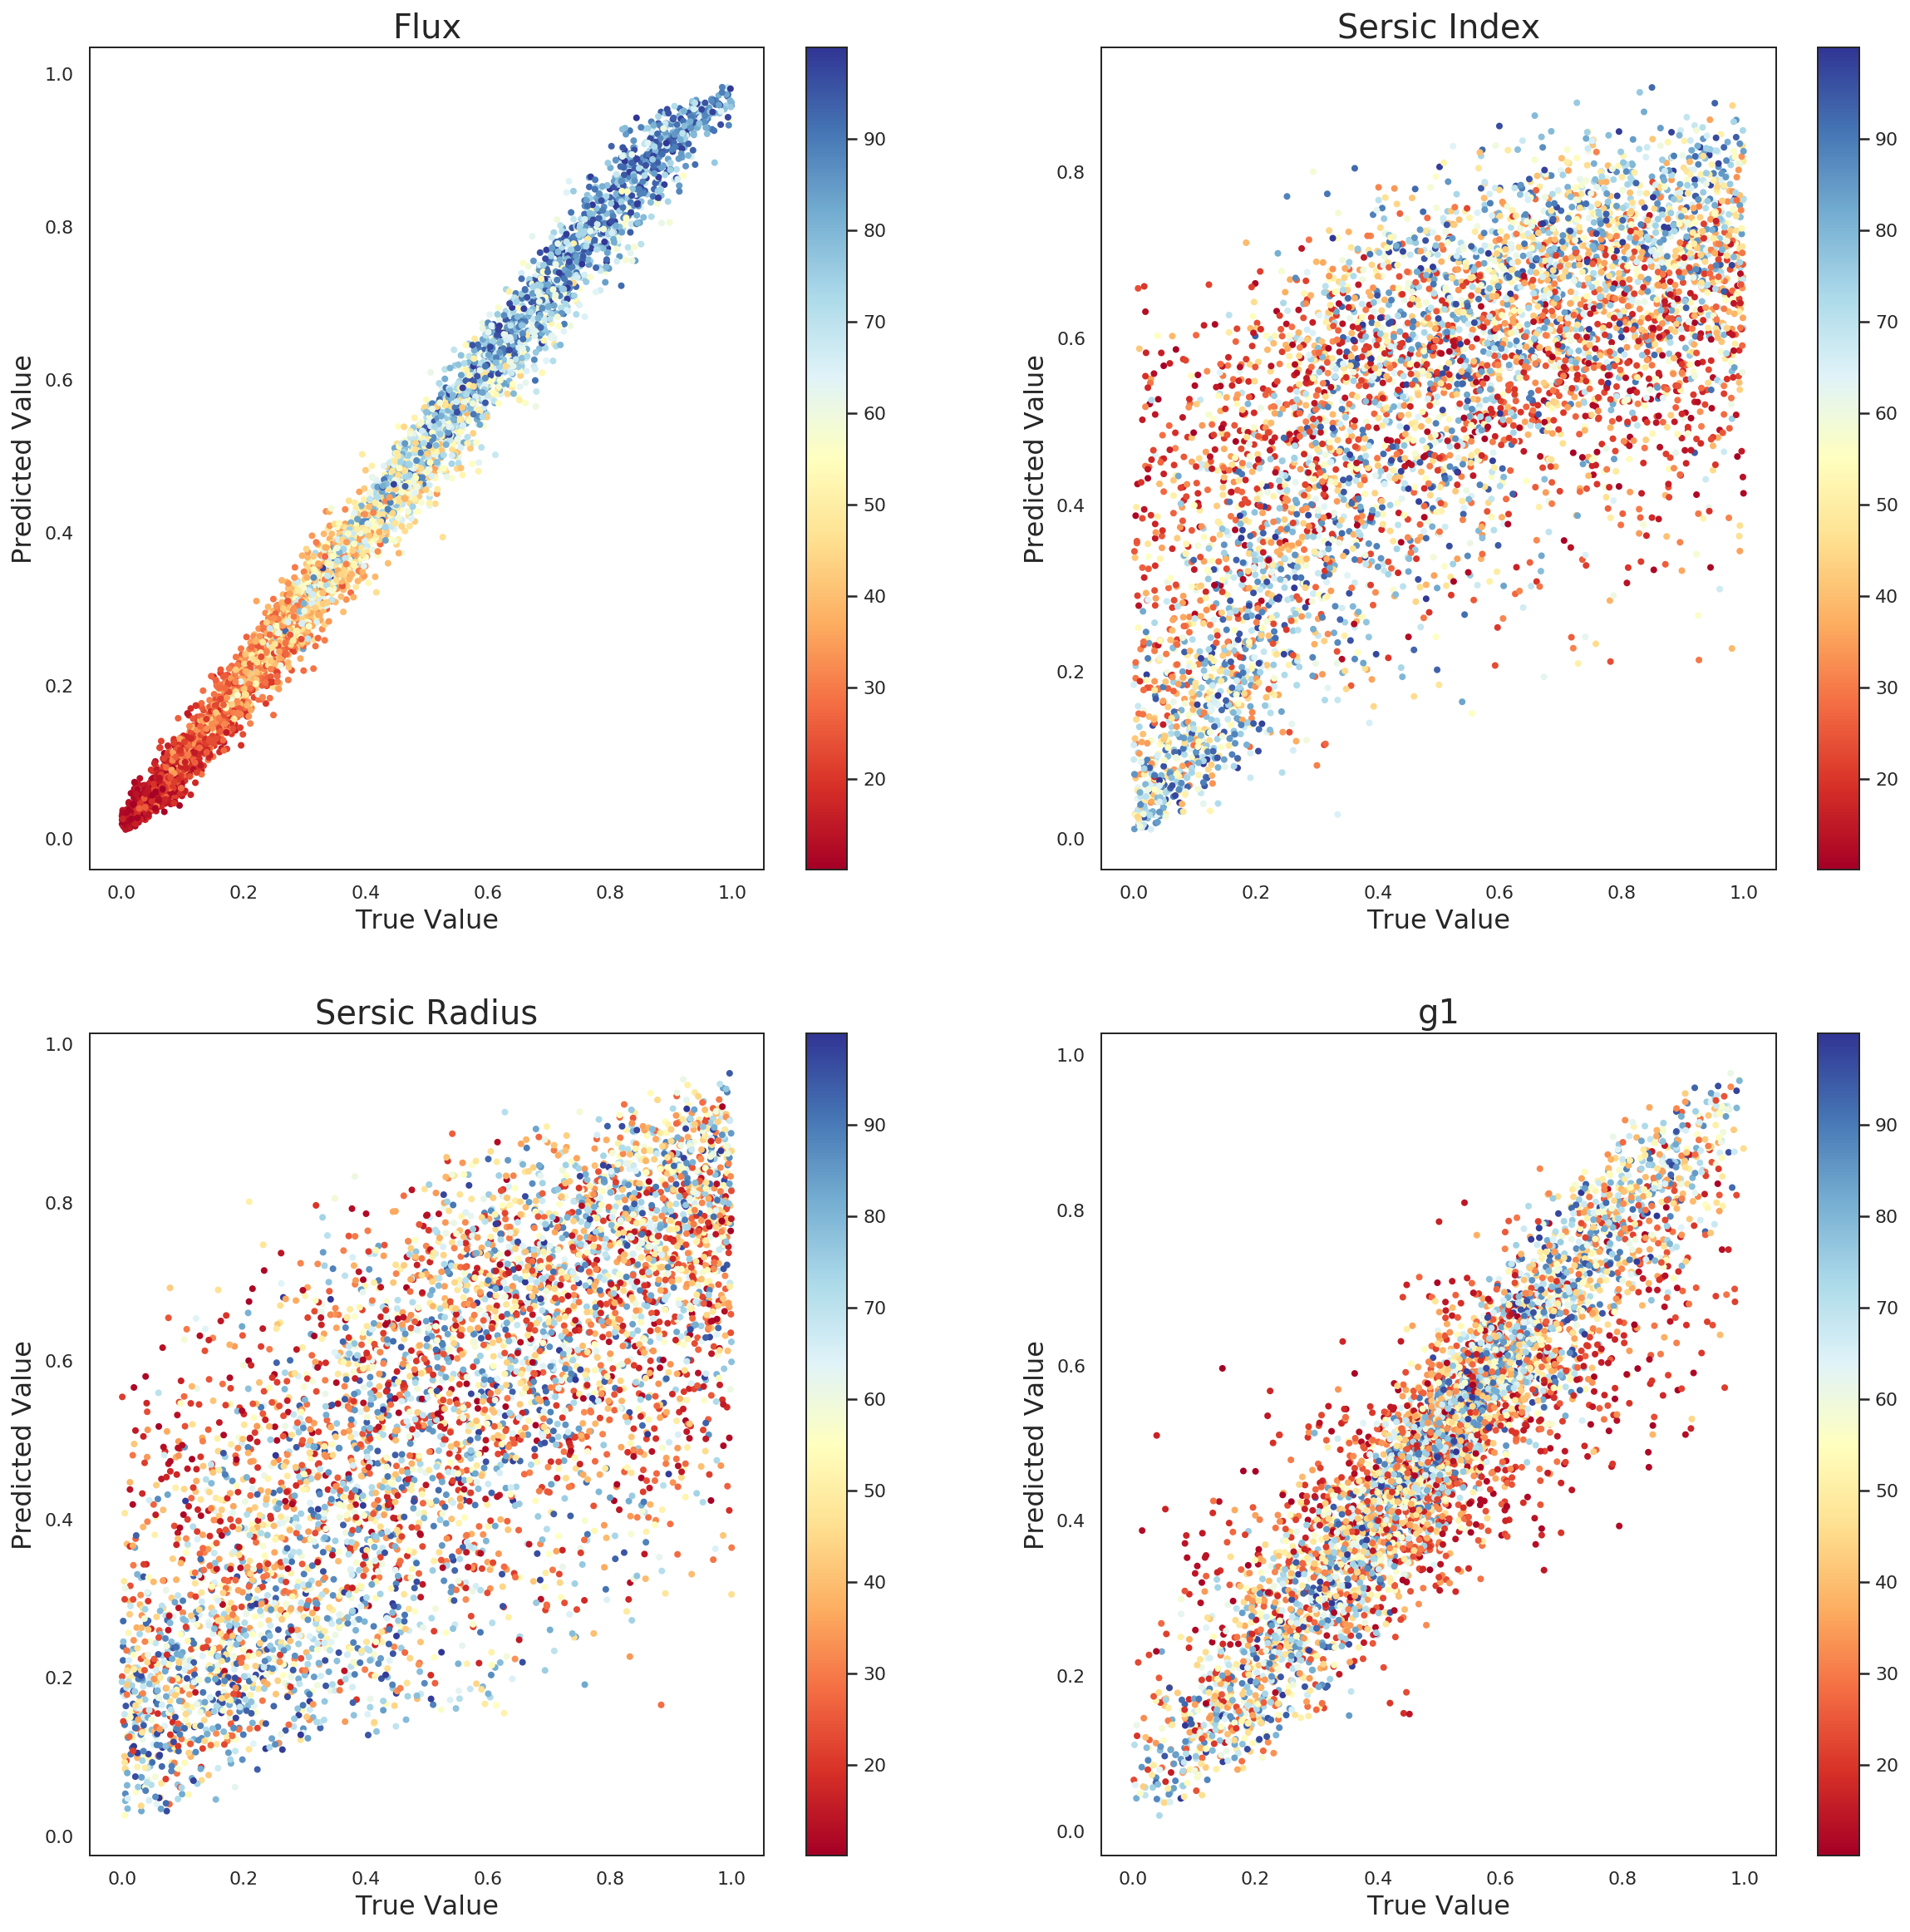

In [46]:
true_vs_pred(pred)

## <div class="theme"> End of Part 3 </div> 

## <div class="theme"> Part 4 </div> 

<div style="border: 3px solid #800080; padding: 10px"> 

## Test Dataset:  SNR = 30


| \# Samples | Avg. SNR | Flux [$10^5$] | Sersic index | Sersic radius | g1     | g2   | PSF  | Noise | Link                                                |
| ---------- | -------- | ------------- | ------------ | ------------- | ------ | ---- | ---- | ----- | --------------------------------------------------- |
| 10,000     | 29.95    | 1.0           | 3.0          | 0.3           | -0.069 | 0.15 | 0.5  | 400   | https://s3.amazonaws.com/measure.galaxies/snr30.npz |

### <div class='exercise'> <b> Step 1: Load the Testing dataset with average SNR of 30 </b> </div>

In [47]:
# Read the data set
(image_test, 
 image_nonoise_test, 
 label_test, 
 snr_test) = load_data(set=4)


Available variables:
    img
    img_nonoise
    label
    psf_r
    psf_img
    snr
    sigma

Image Shape            = (10000, 64, 64)
No-noise Image Shape   = (10000, 64, 64)
Label Shape            = (10000, 5)
SNR Shape              = (10000,)
Sigma Shape            = (10000,)
PSF-R Shape            = (10000,)


### <div class='exercise'> <b> Step 2: Split the data into Training and Validation, Normalize the data and Generate Image Pixel Statistics </b> </div>

In [48]:
(image_test,
 image_nonoise_test,
 label_test, 
 stats_test) = norm_test_data(
    image_test, 
    image_nonoise_test, 
    label_test,  
    scaler_label2,
    scaler_image2,
    scaler_nonoise2)

### <div class='exercise'> <b> Step 3: Create Data Pipeline </b> </div>

<div class='gc'> <b> Function to Load Data and Divide data into Training and Validation Set </b> </div>

In [49]:
# Create Tensorflow Dataset
testing = create_dataset(test=True)

<div class='gc'> <b> Create dataset pipeline </b> </div>

In [50]:
test_ds = create_data_pipeline(testing, test=True)

### <div class='exercise'> <b> Step 4: Load Conditional Auto-encoder trained with variable Noise and fixed PSF </b> </div>

In [51]:
CAE.load_weights(paths[1])

### <div class='exercise'> <b> Step 5: Performance Analysis </b> </div>

<div class='gc'> <b> Generating reconstructed images for visual inspection </b> </div>

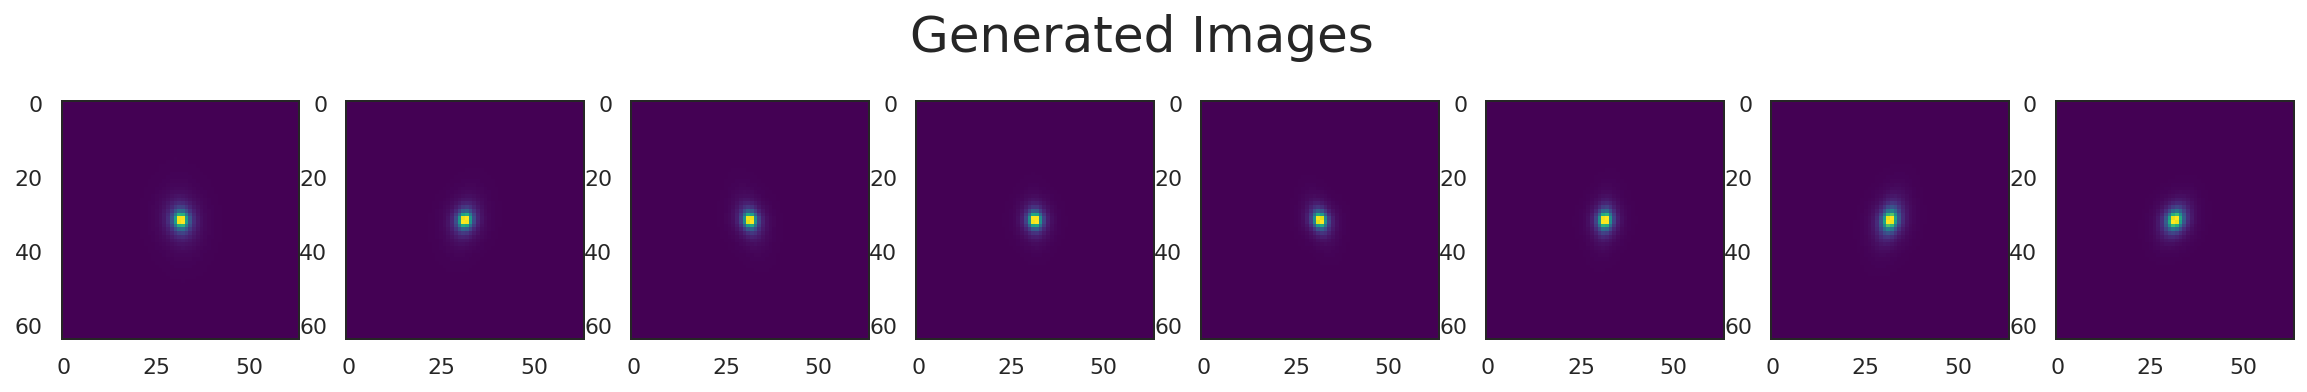

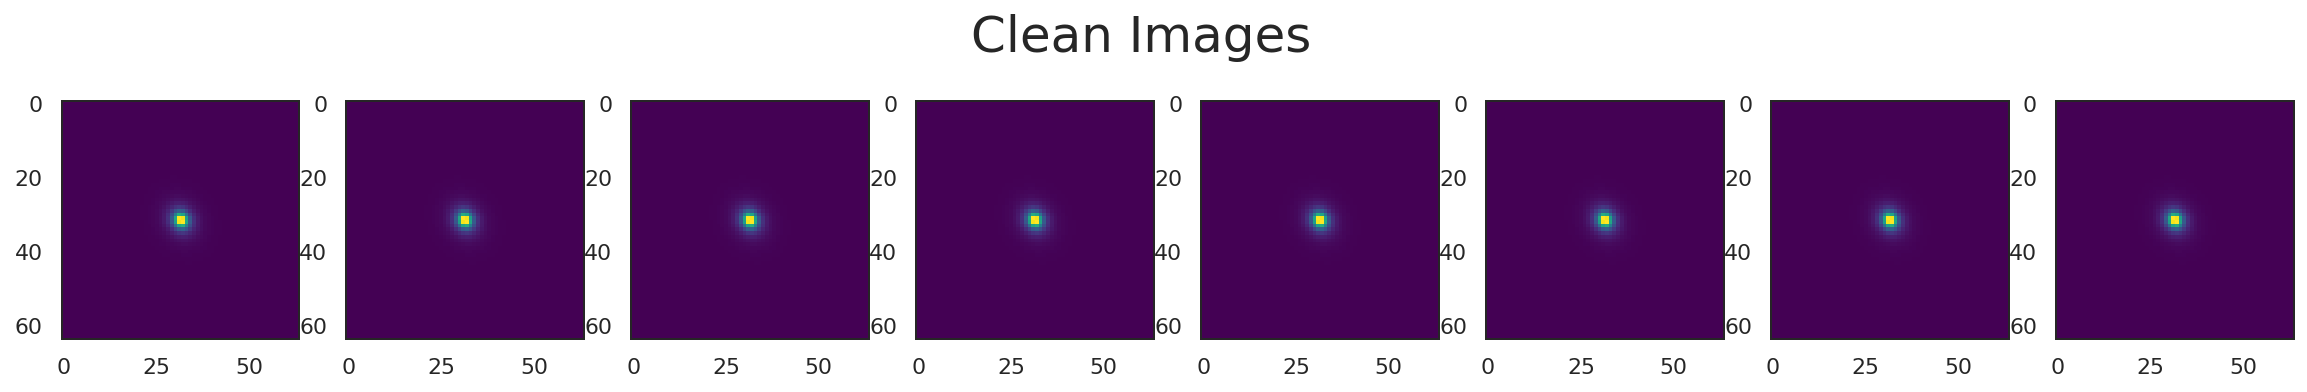

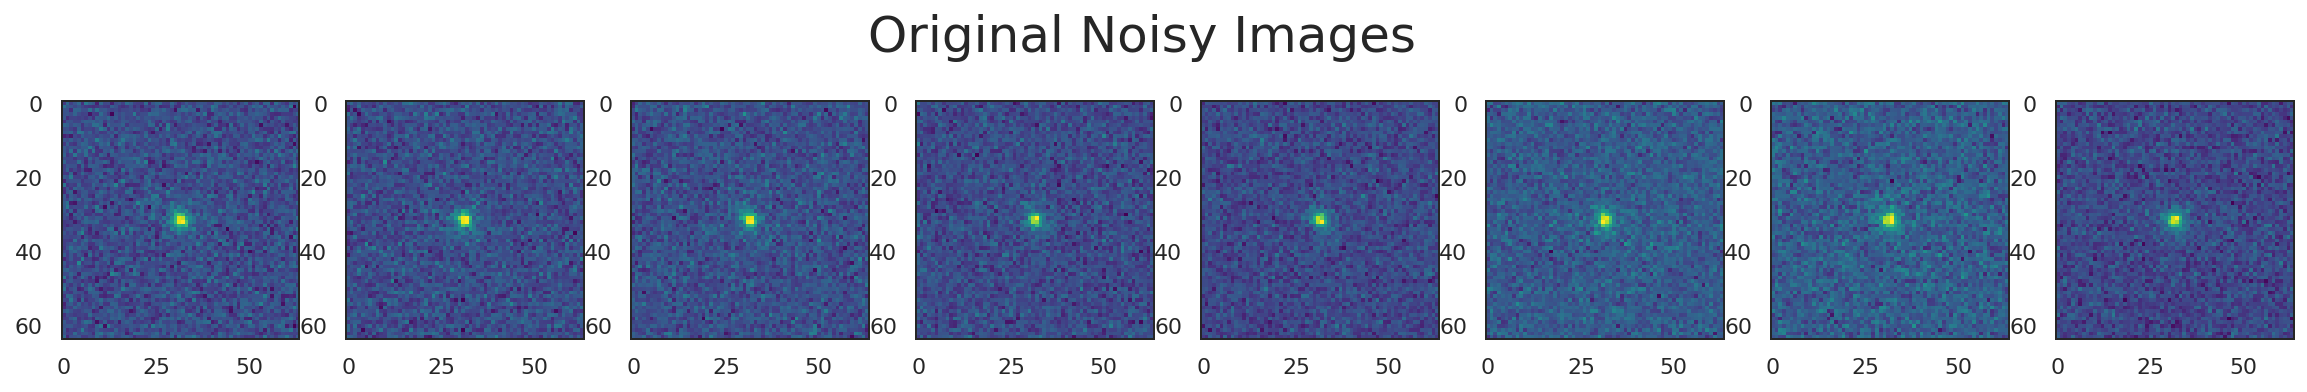

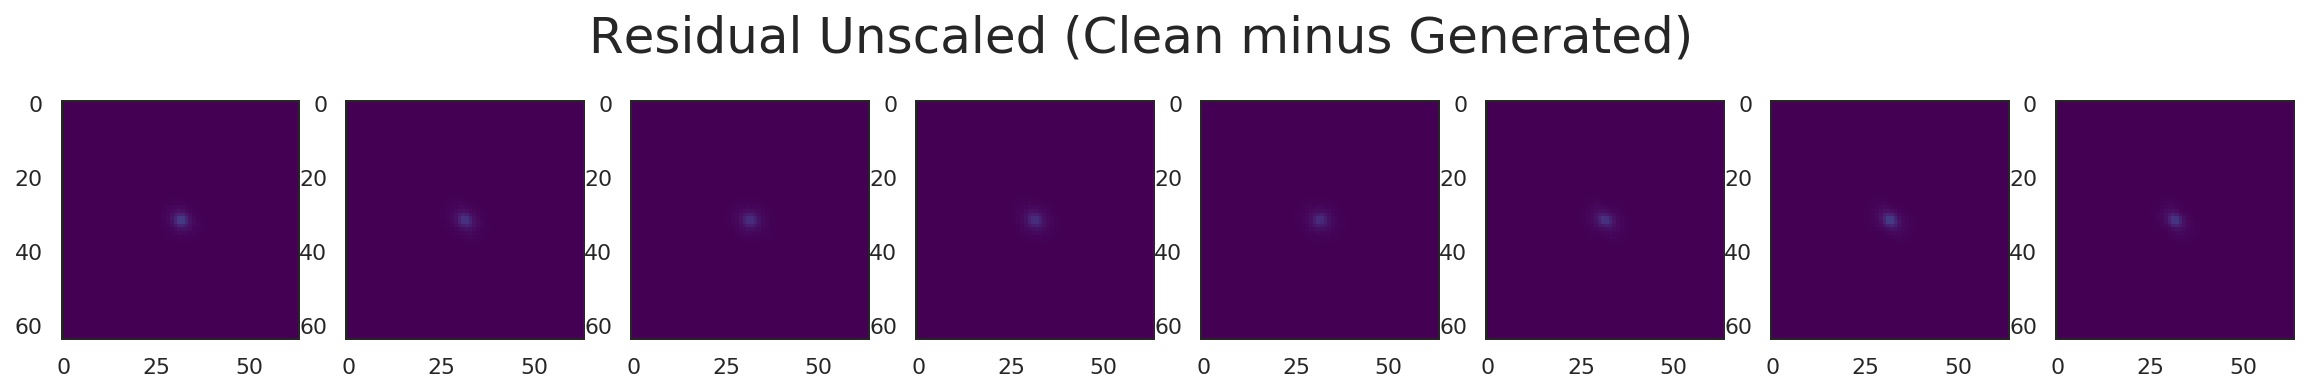

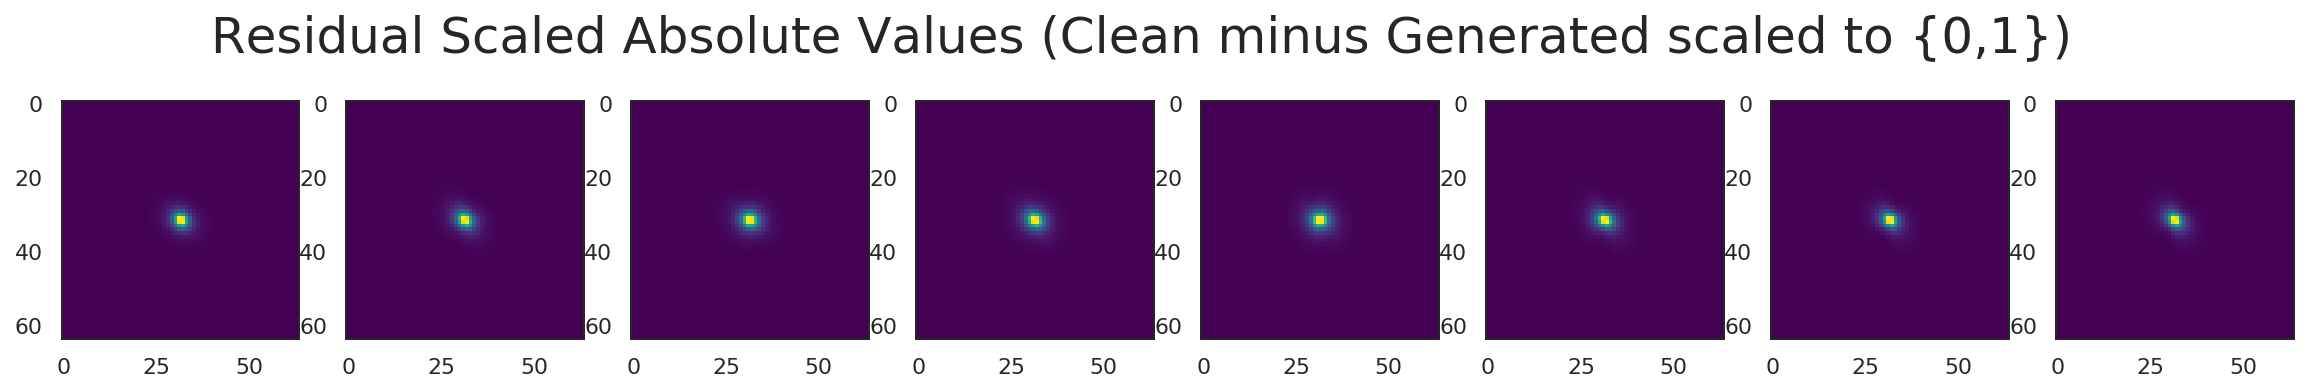

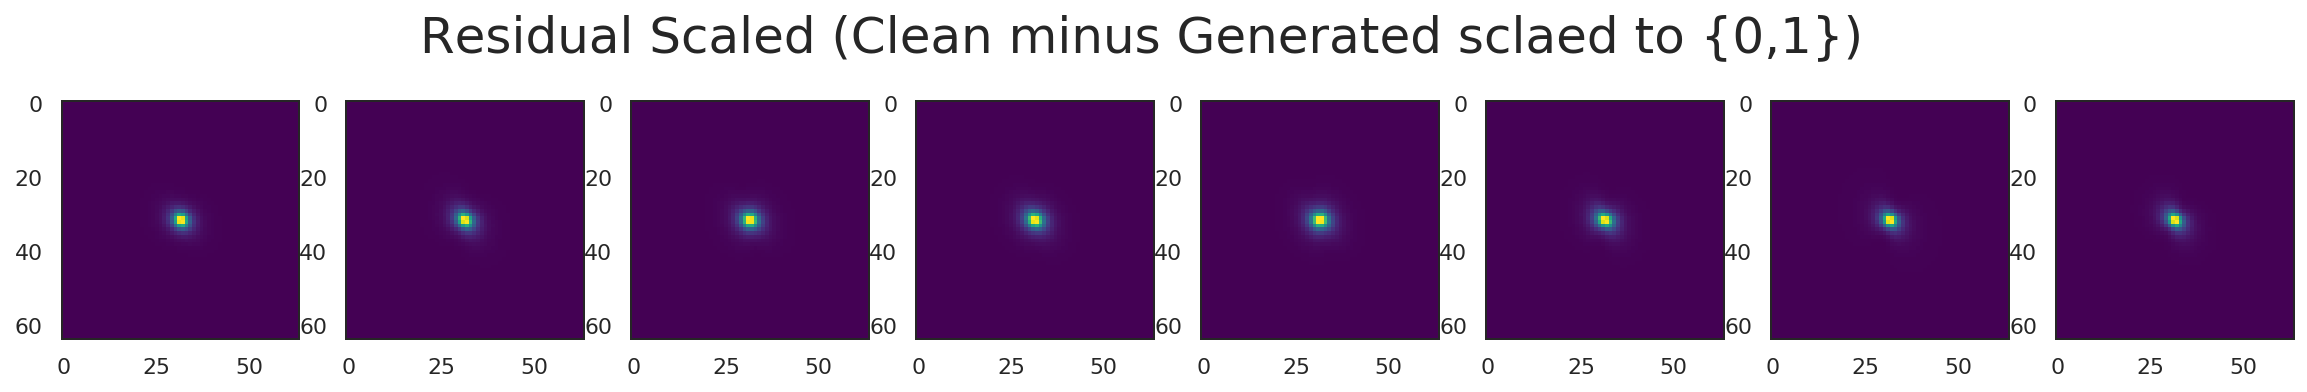

In [52]:
generate_images(CAE, test_ds)

<div class='gc'> <b> Variance Analysis for Label </b> </div>

In [53]:
pred = variance_analysis(CAE, test_ds, scaler_label2, label_test, test=True)

Bias          RMSE
Flux          -58981.023438  59013.292969
Sersic Index       0.258959      1.294542
Sersic Radius     -0.028627      0.094017
g1                -0.267443      0.302026
g2                -0.238636      0.299554

## <div class="theme"> End of Part 4 </div> 

## <div class="theme"> Part 5 </div> 

<div style="border: 3px solid #800080; padding: 10px"> 

## Test Dataset:  SNR = 60


| \# Samples | Avg. SNR | Flux [$10^5$] | Sersic index | Sersic radius | g1     | g2   | PSF  | Noise | Link                                                |
| ---------- | -------- | ------------- | ------------ | ------------- | ------ | ---- | ---- | ----- | --------------------------------------------------- |
| 10,000     | 59.90    | 1.0           | 3.0          | 0.3           | -0.069 | 0.15 | 0.5  | 200   | https://s3.amazonaws.com/measure.galaxies/snr60.npz |

### <div class='exercise'> <b> Step 1: Load the Testing dataset with average SNR of 30 </b> </div>

In [54]:
# Read the data set
(image_test, 
 image_nonoise_test, 
 label_test, 
 snr_test) = load_data(set=5)


Available variables:
    img
    img_nonoise
    label
    psf_r
    psf_img
    snr
    sigma

Image Shape            = (10000, 64, 64)
No-noise Image Shape   = (10000, 64, 64)
Label Shape            = (10000, 5)
SNR Shape              = (10000,)
Sigma Shape            = (10000,)
PSF-R Shape            = (10000,)


### <div class='exercise'> <b> Step 2: Split the data into Training and Validation, Normalize the data and Generate Image Pixel Statistics </b> </div>

In [55]:
(image_test,
 image_nonoise_test,
 label_test, 
 stats_test) = norm_test_data(
    image_test, 
    image_nonoise_test, 
    label_test,  
    scaler_label1,
    scaler_image1,
    scaler_nonoise1)

### <div class='exercise'> <b> Step 3: Create Data Pipeline </b> </div>

<div class='gc'> <b> Function to Load Data and Divide data into Training and Validation Set </b> </div>

In [56]:
# Create Tensorflow Dataset
testing = create_dataset(test=True)

<div class='gc'> <b> Create dataset pipeline </b> </div>

In [57]:
test_ds = create_data_pipeline(testing, test=True)

### <div class='exercise'> <b> Step 4: Load Conditional Auto-encoder trained with variable Noise and fixed PSF </b> </div>

In [58]:
CAE.load_weights(paths[0])

### <div class='exercise'> <b> Step 5: Performance Analysis </b> </div>

<div class='gc'> <b> Generating reconstructed images for visual inspection </b> </div>

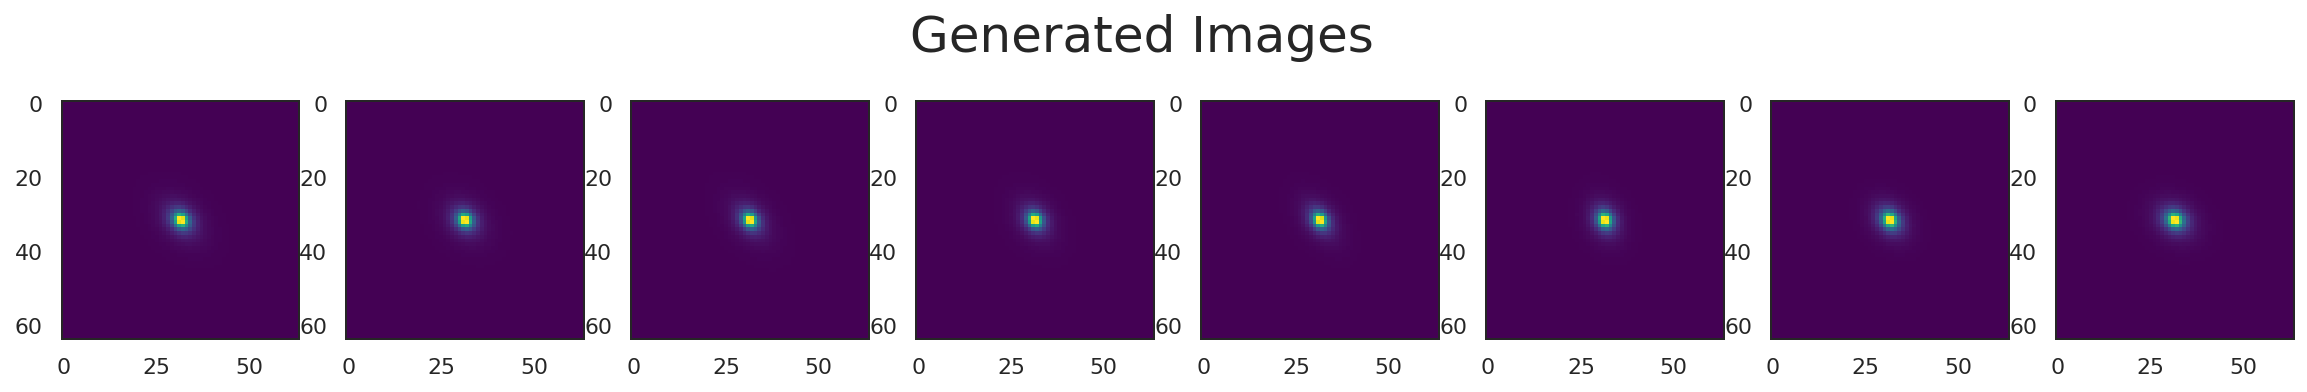

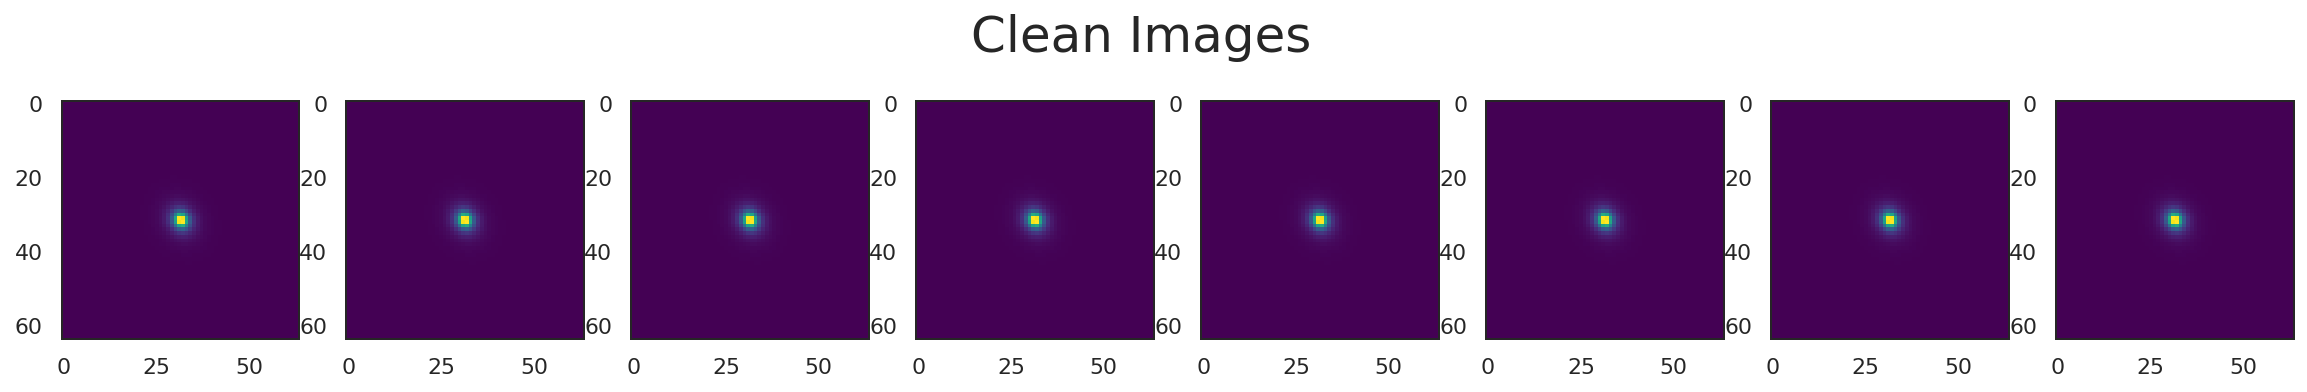

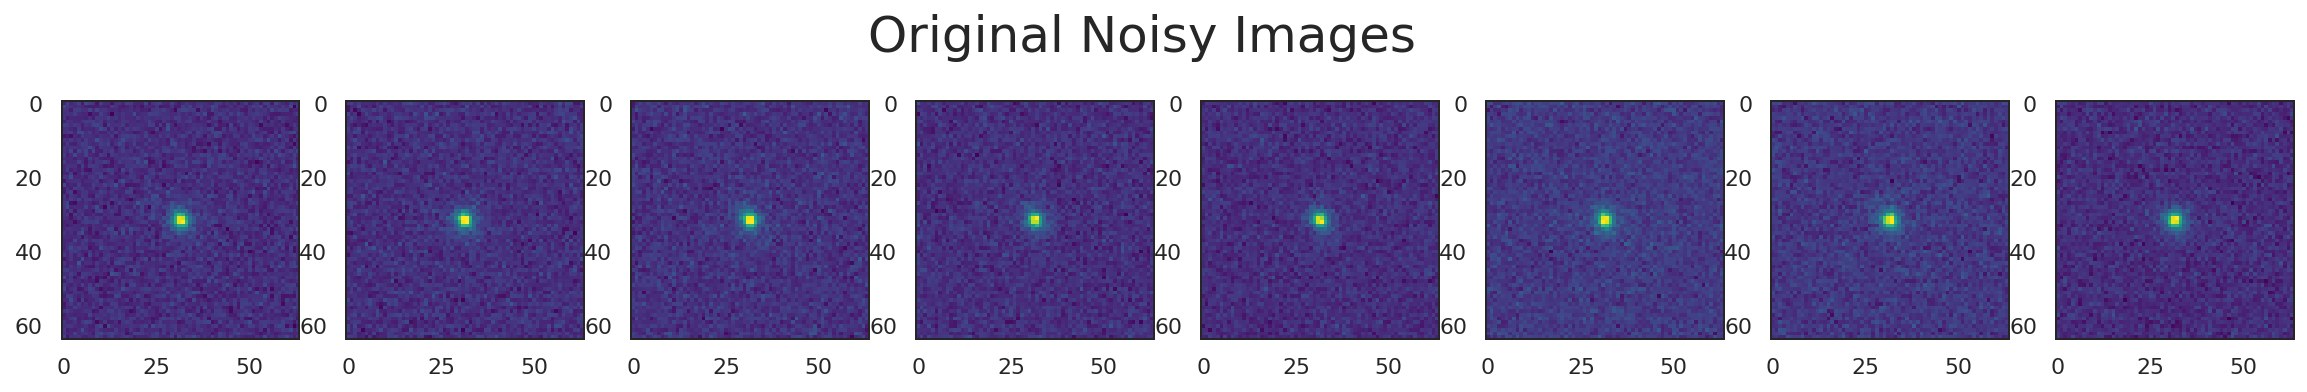

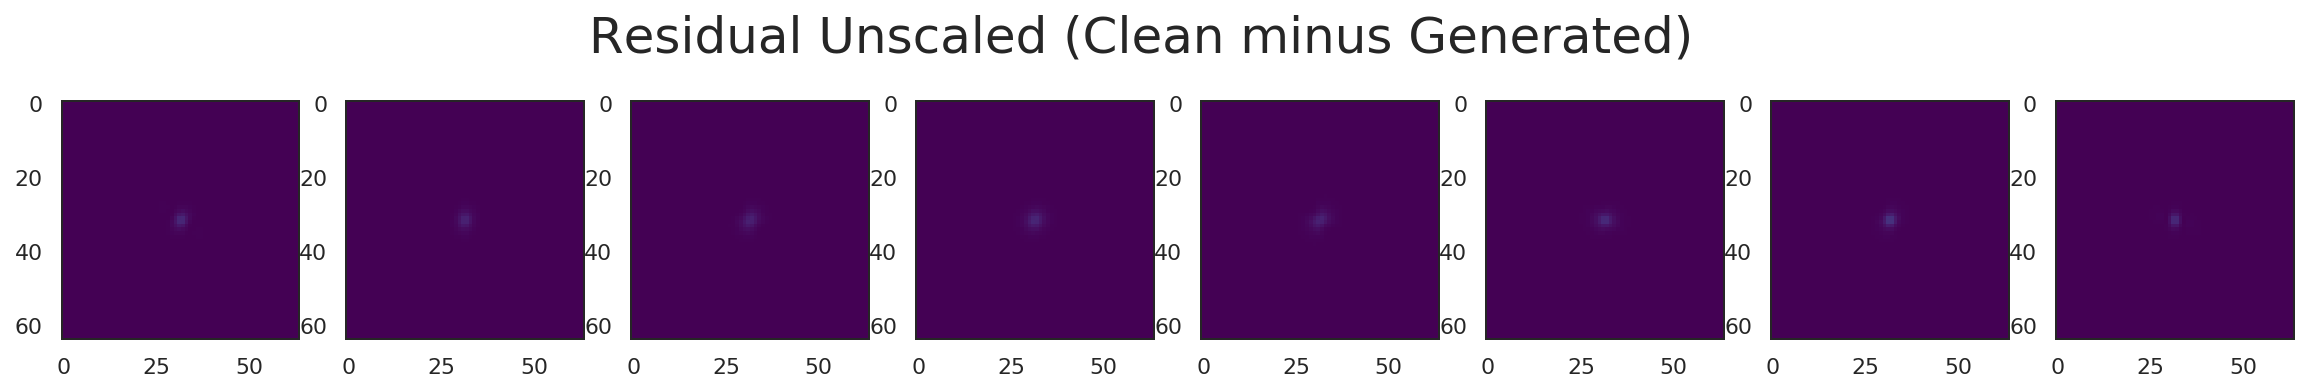

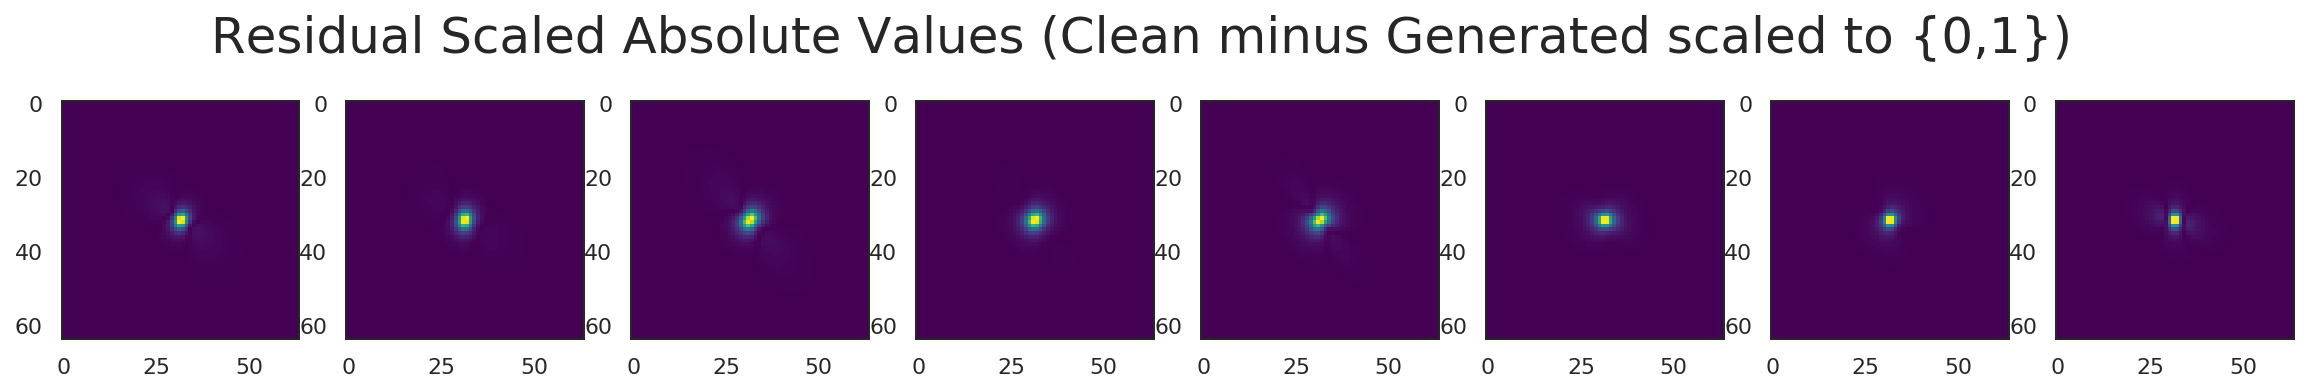

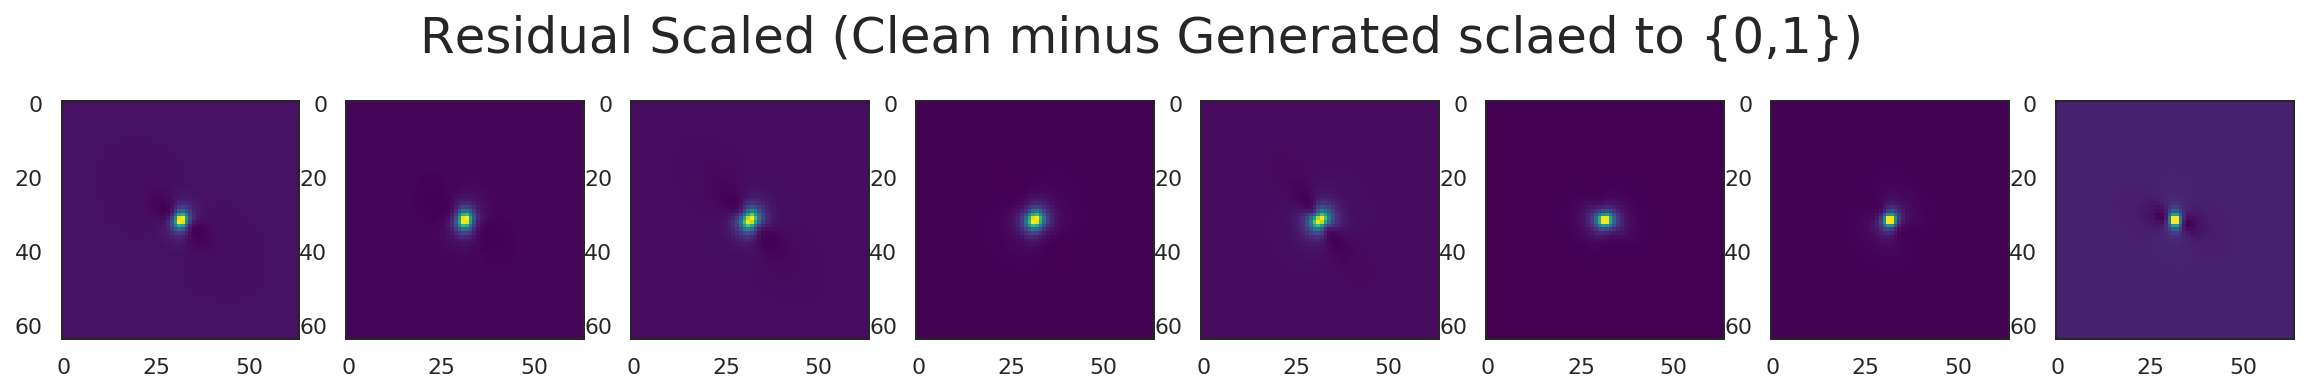

In [59]:
generate_images(CAE, test_ds)

<div class='gc'> <b> Variance Analysis for Label </b> </div>

In [60]:
pred = variance_analysis(CAE, test_ds, scaler_label1, label_test, test=True)

Bias          RMSE
Flux          -13115.263672  14862.901367
Sersic Index       0.126857      0.990233
Sersic Radius      0.048741      0.071625
g1                 0.019908      0.079389
g2                 0.071002      0.099121

## <div class="theme"> End of Part 5 </div> 

## <div class="theme"> Summary </div> 

<div style="border: 3px solid #800080; padding: 10px"> 
    
### ***Shape and Brightness of a Galaxy***


# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png">  End Of Project
